In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 38
Bad channel: 38
Bad channel: 58


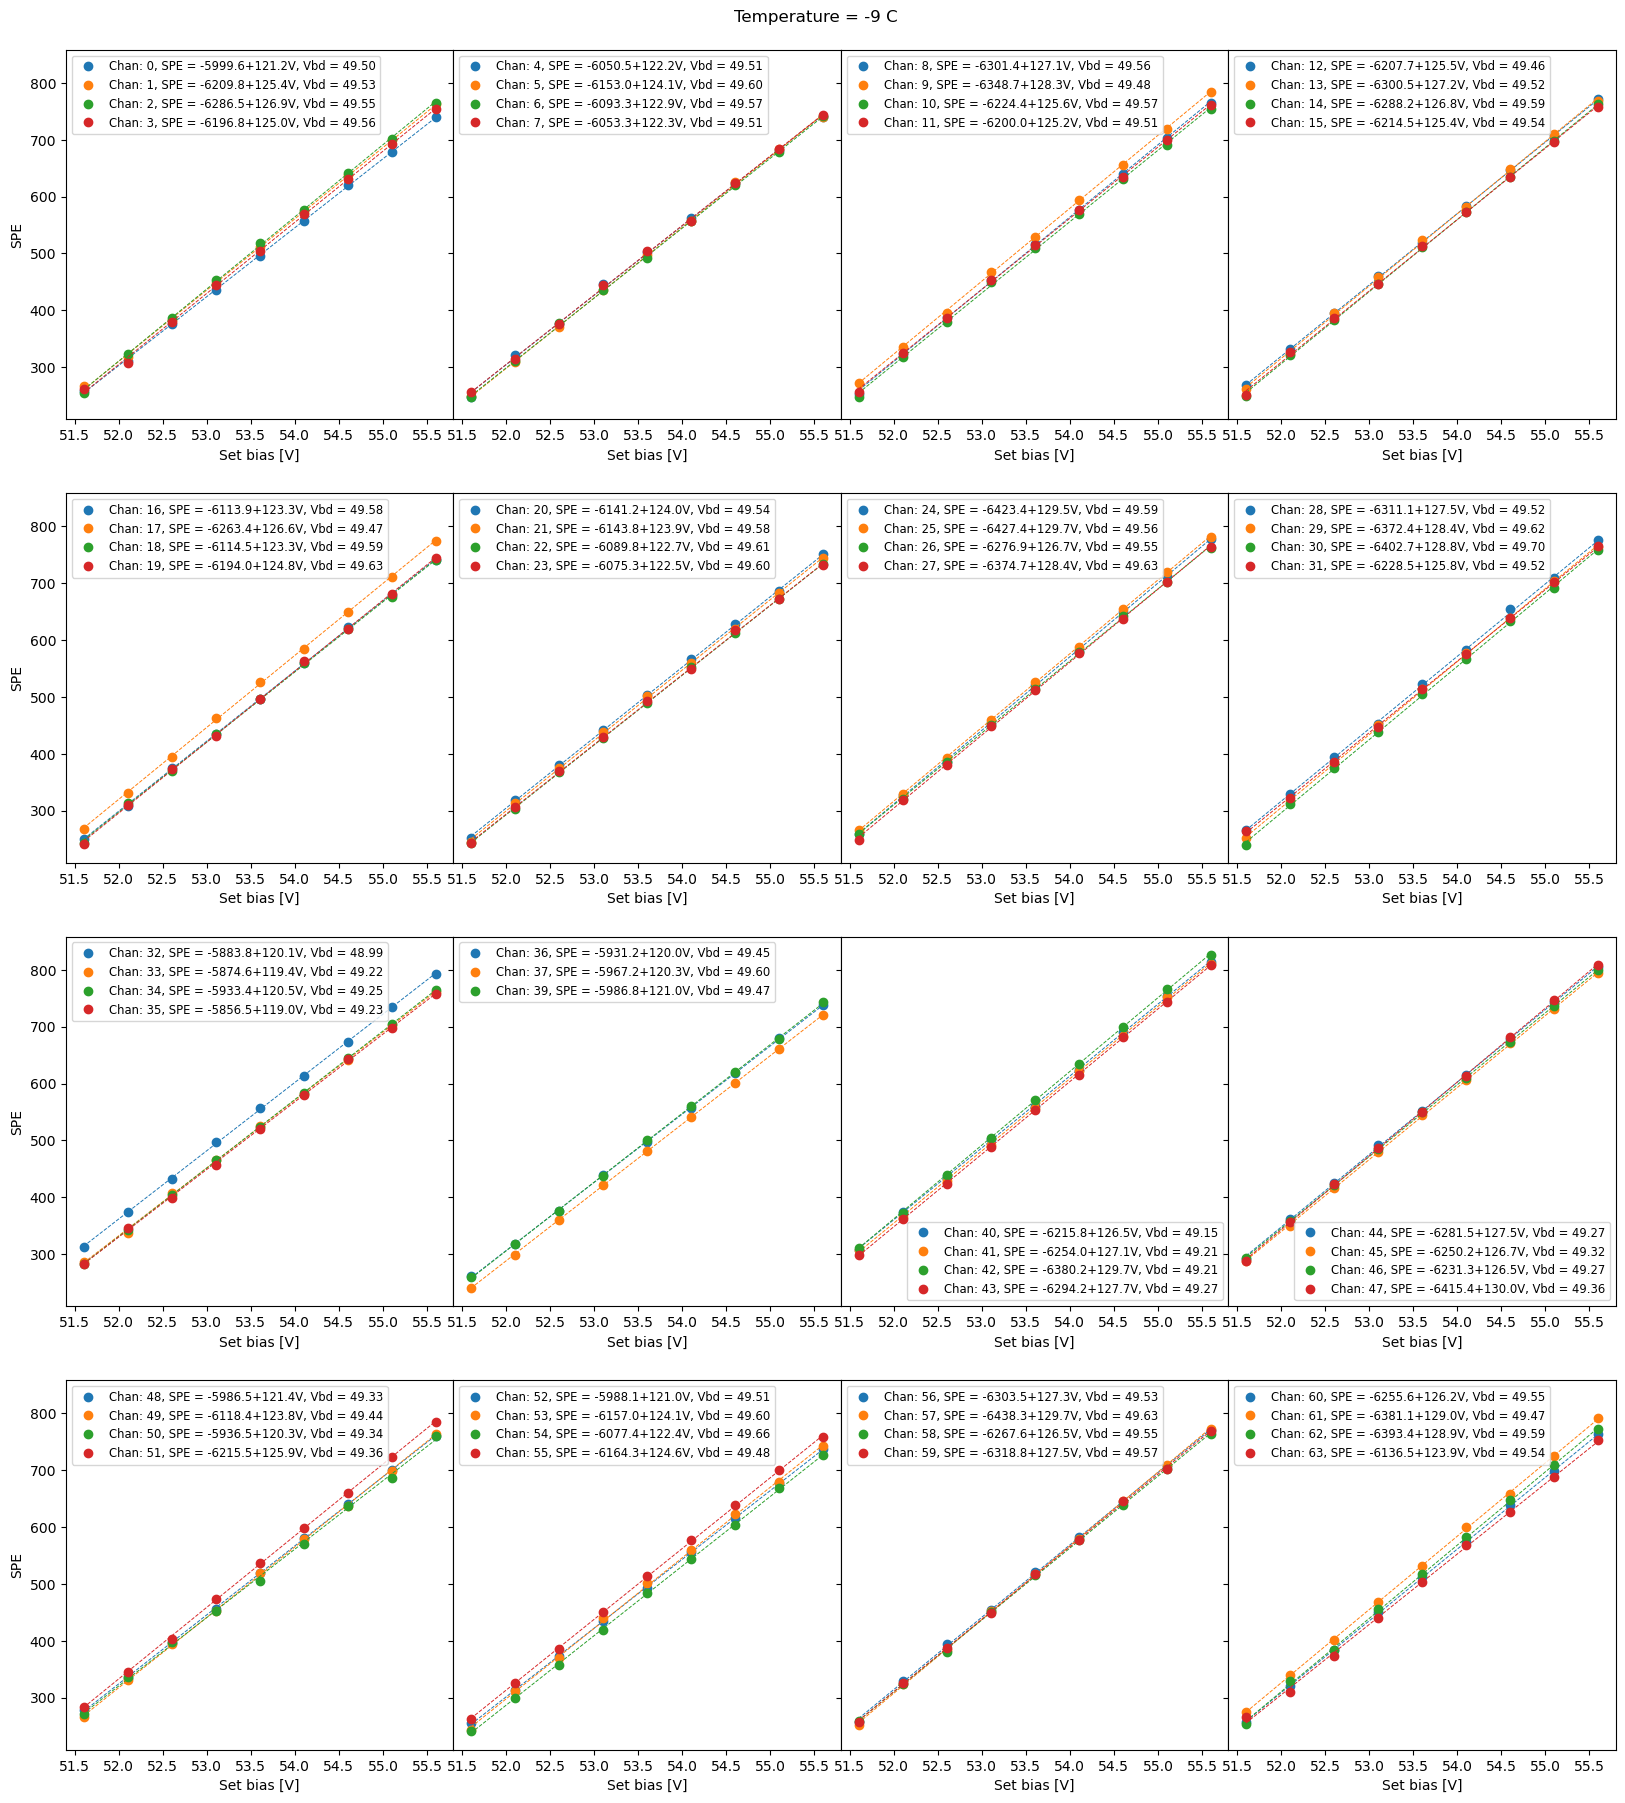

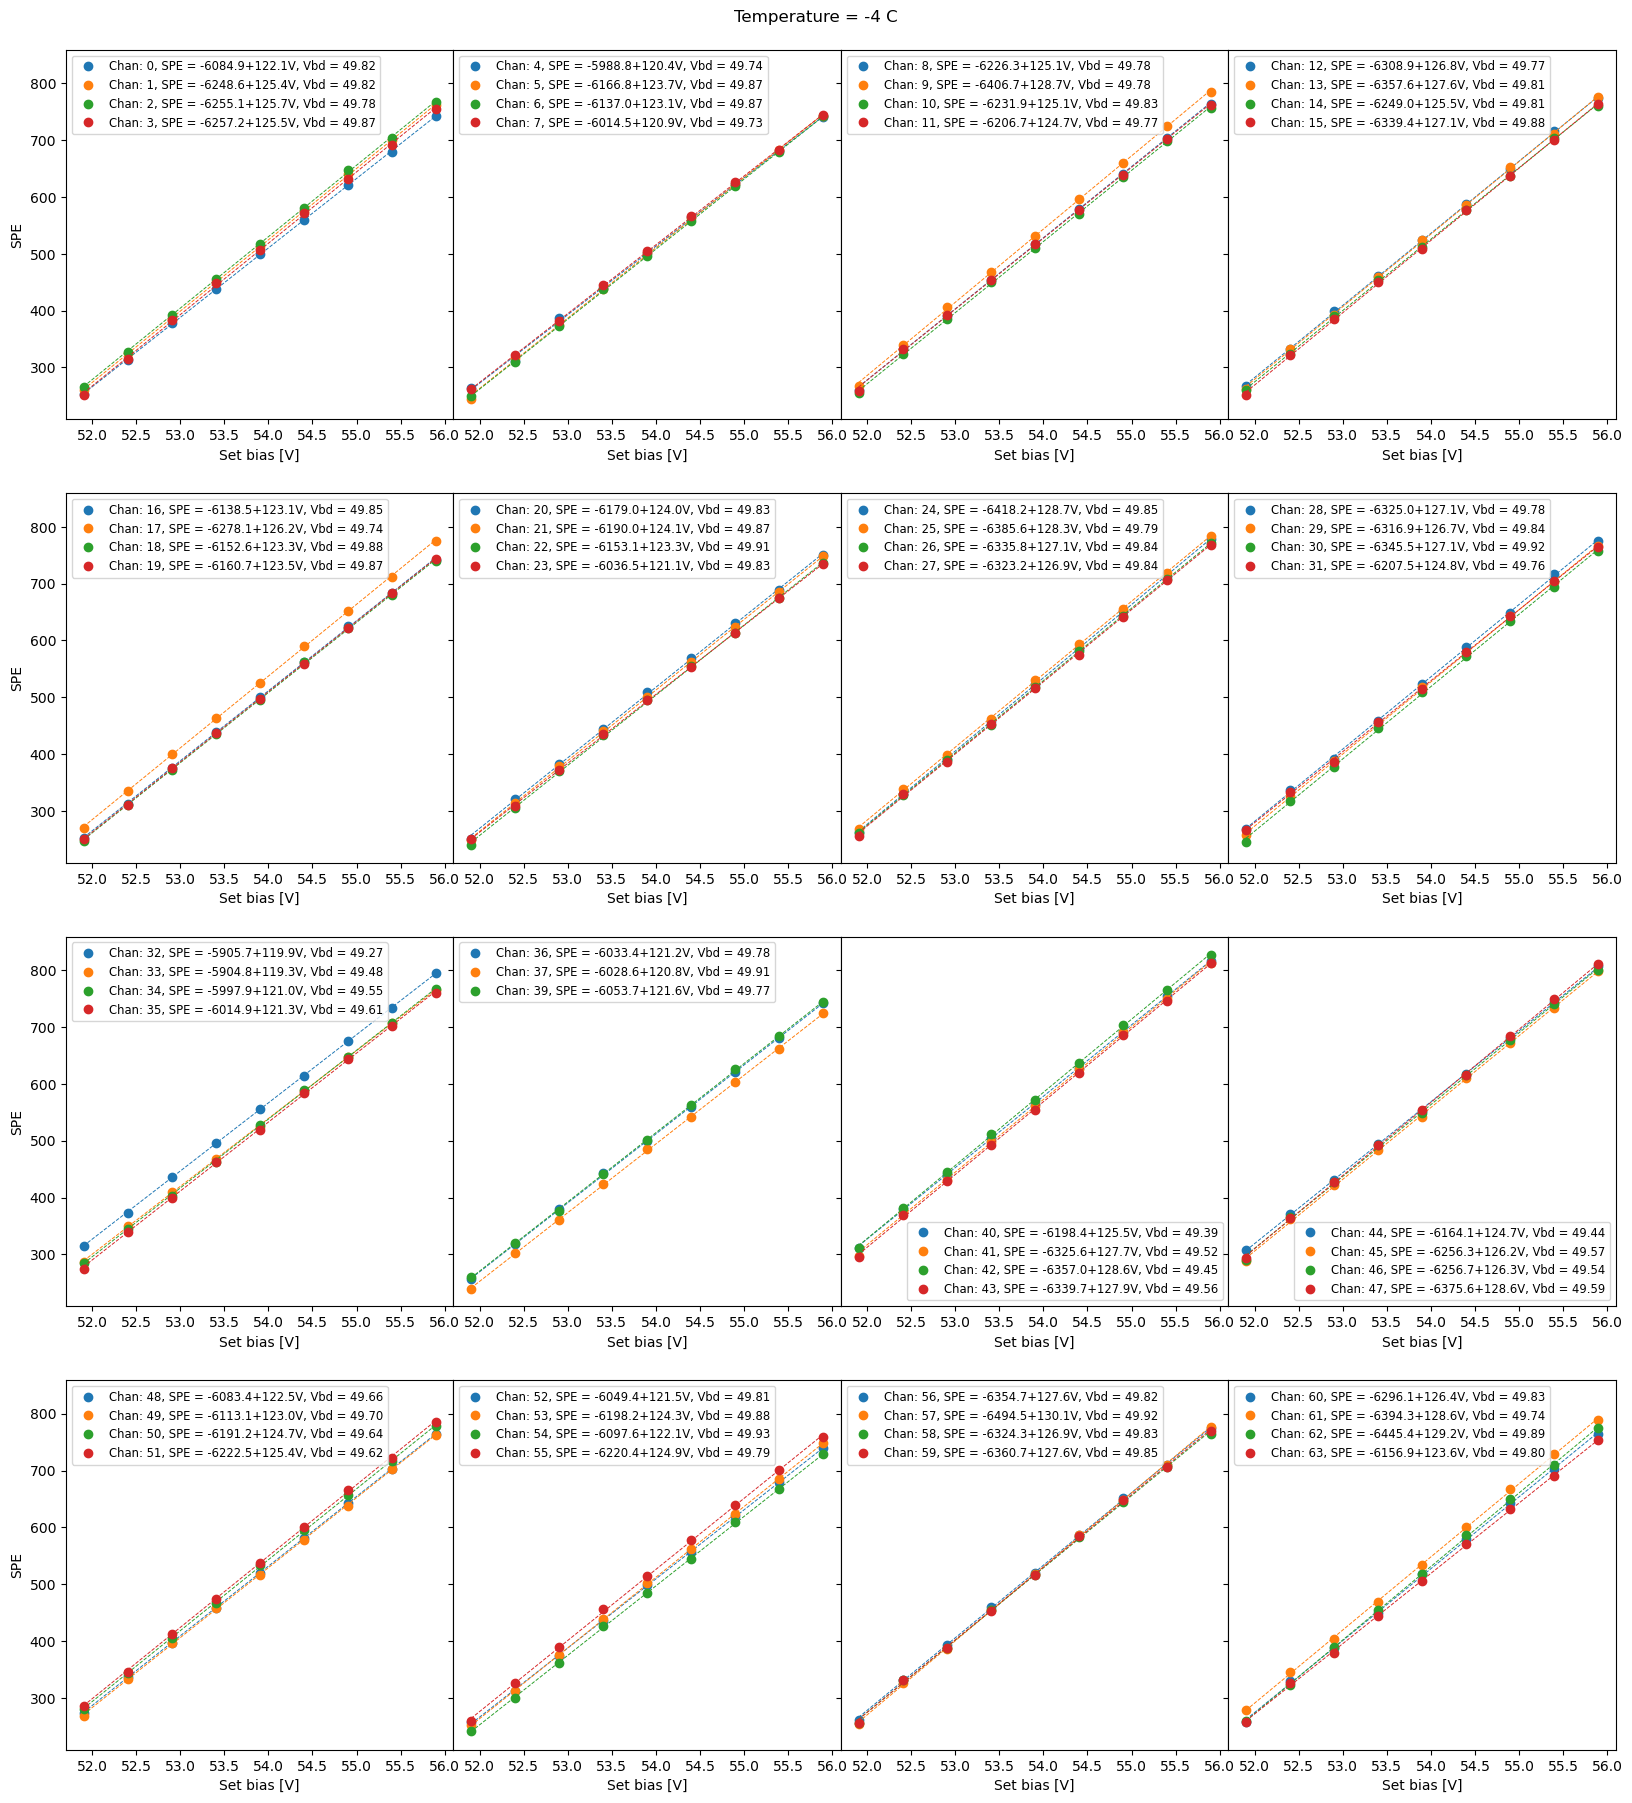

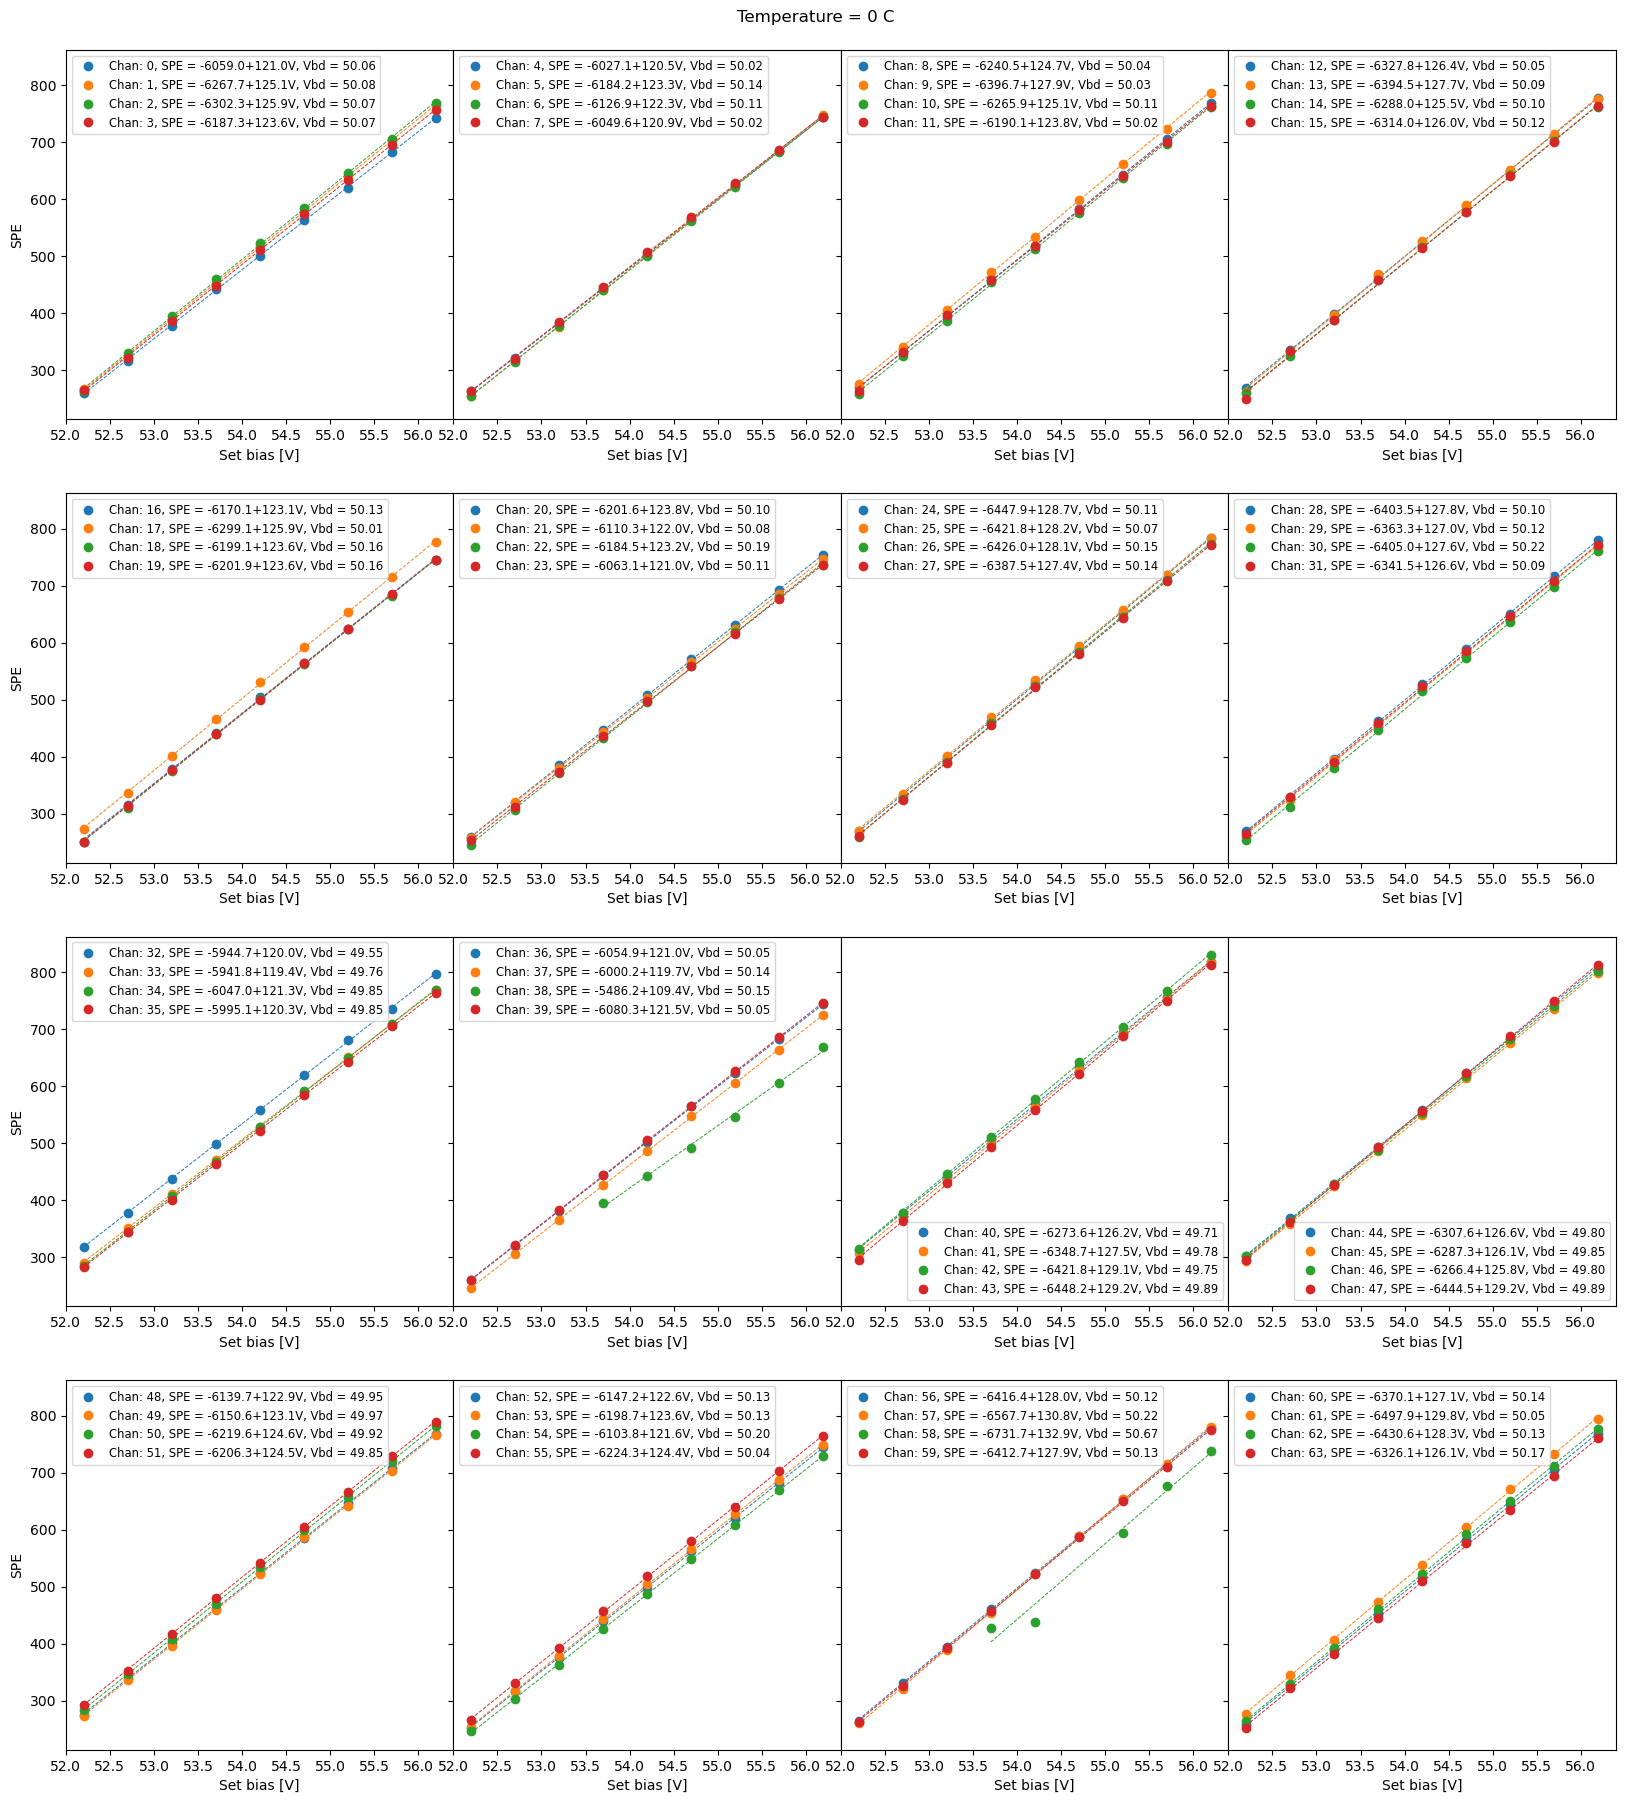

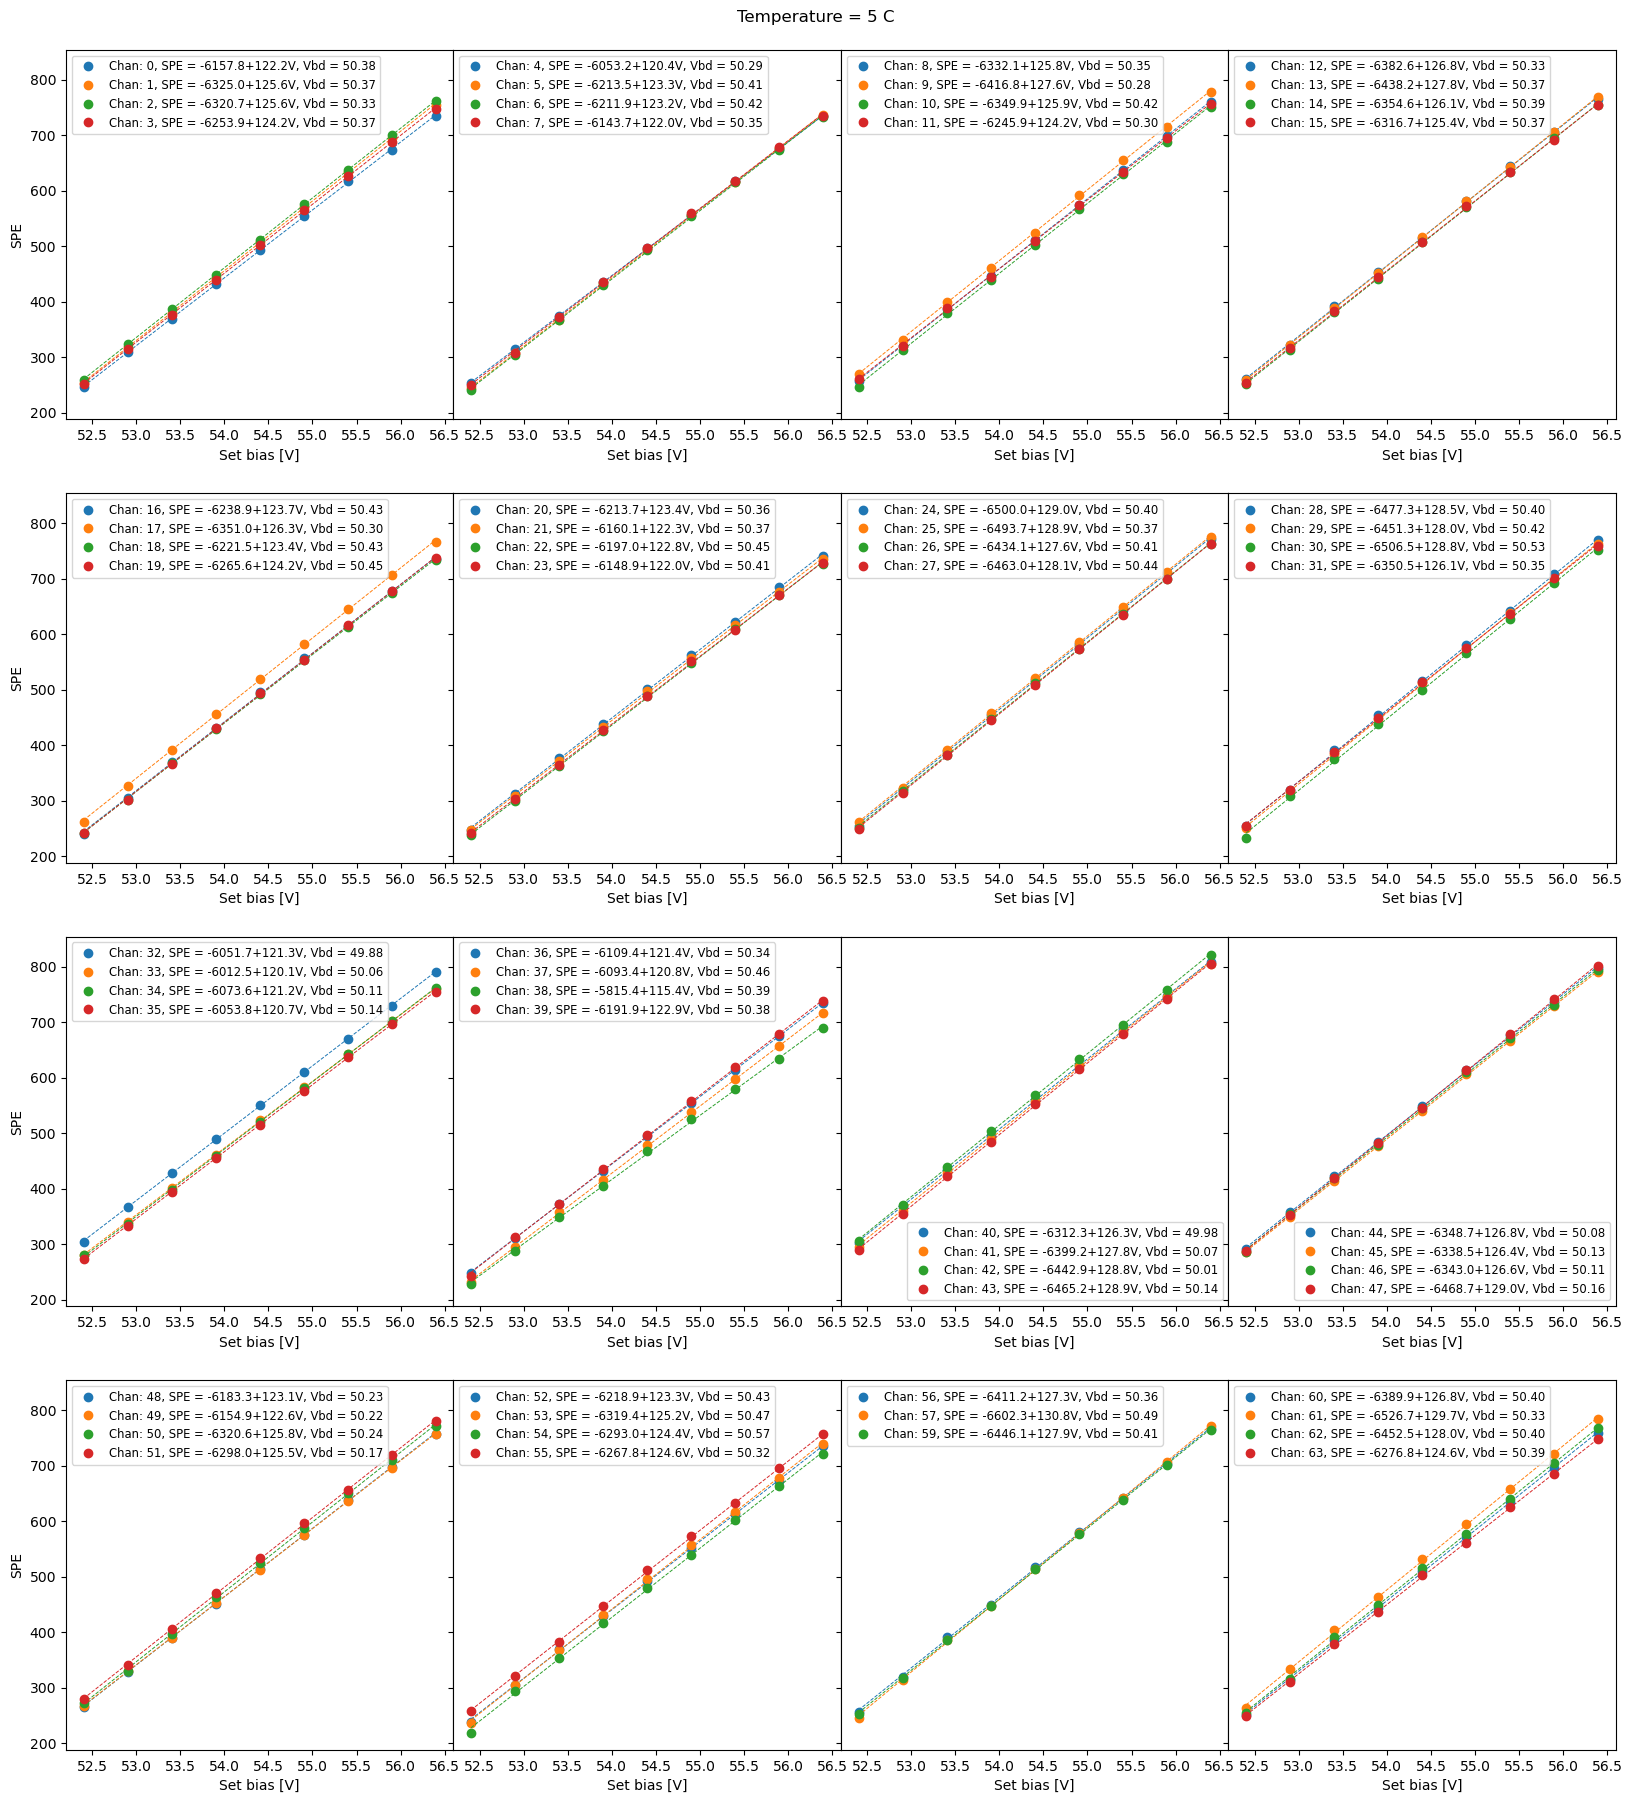

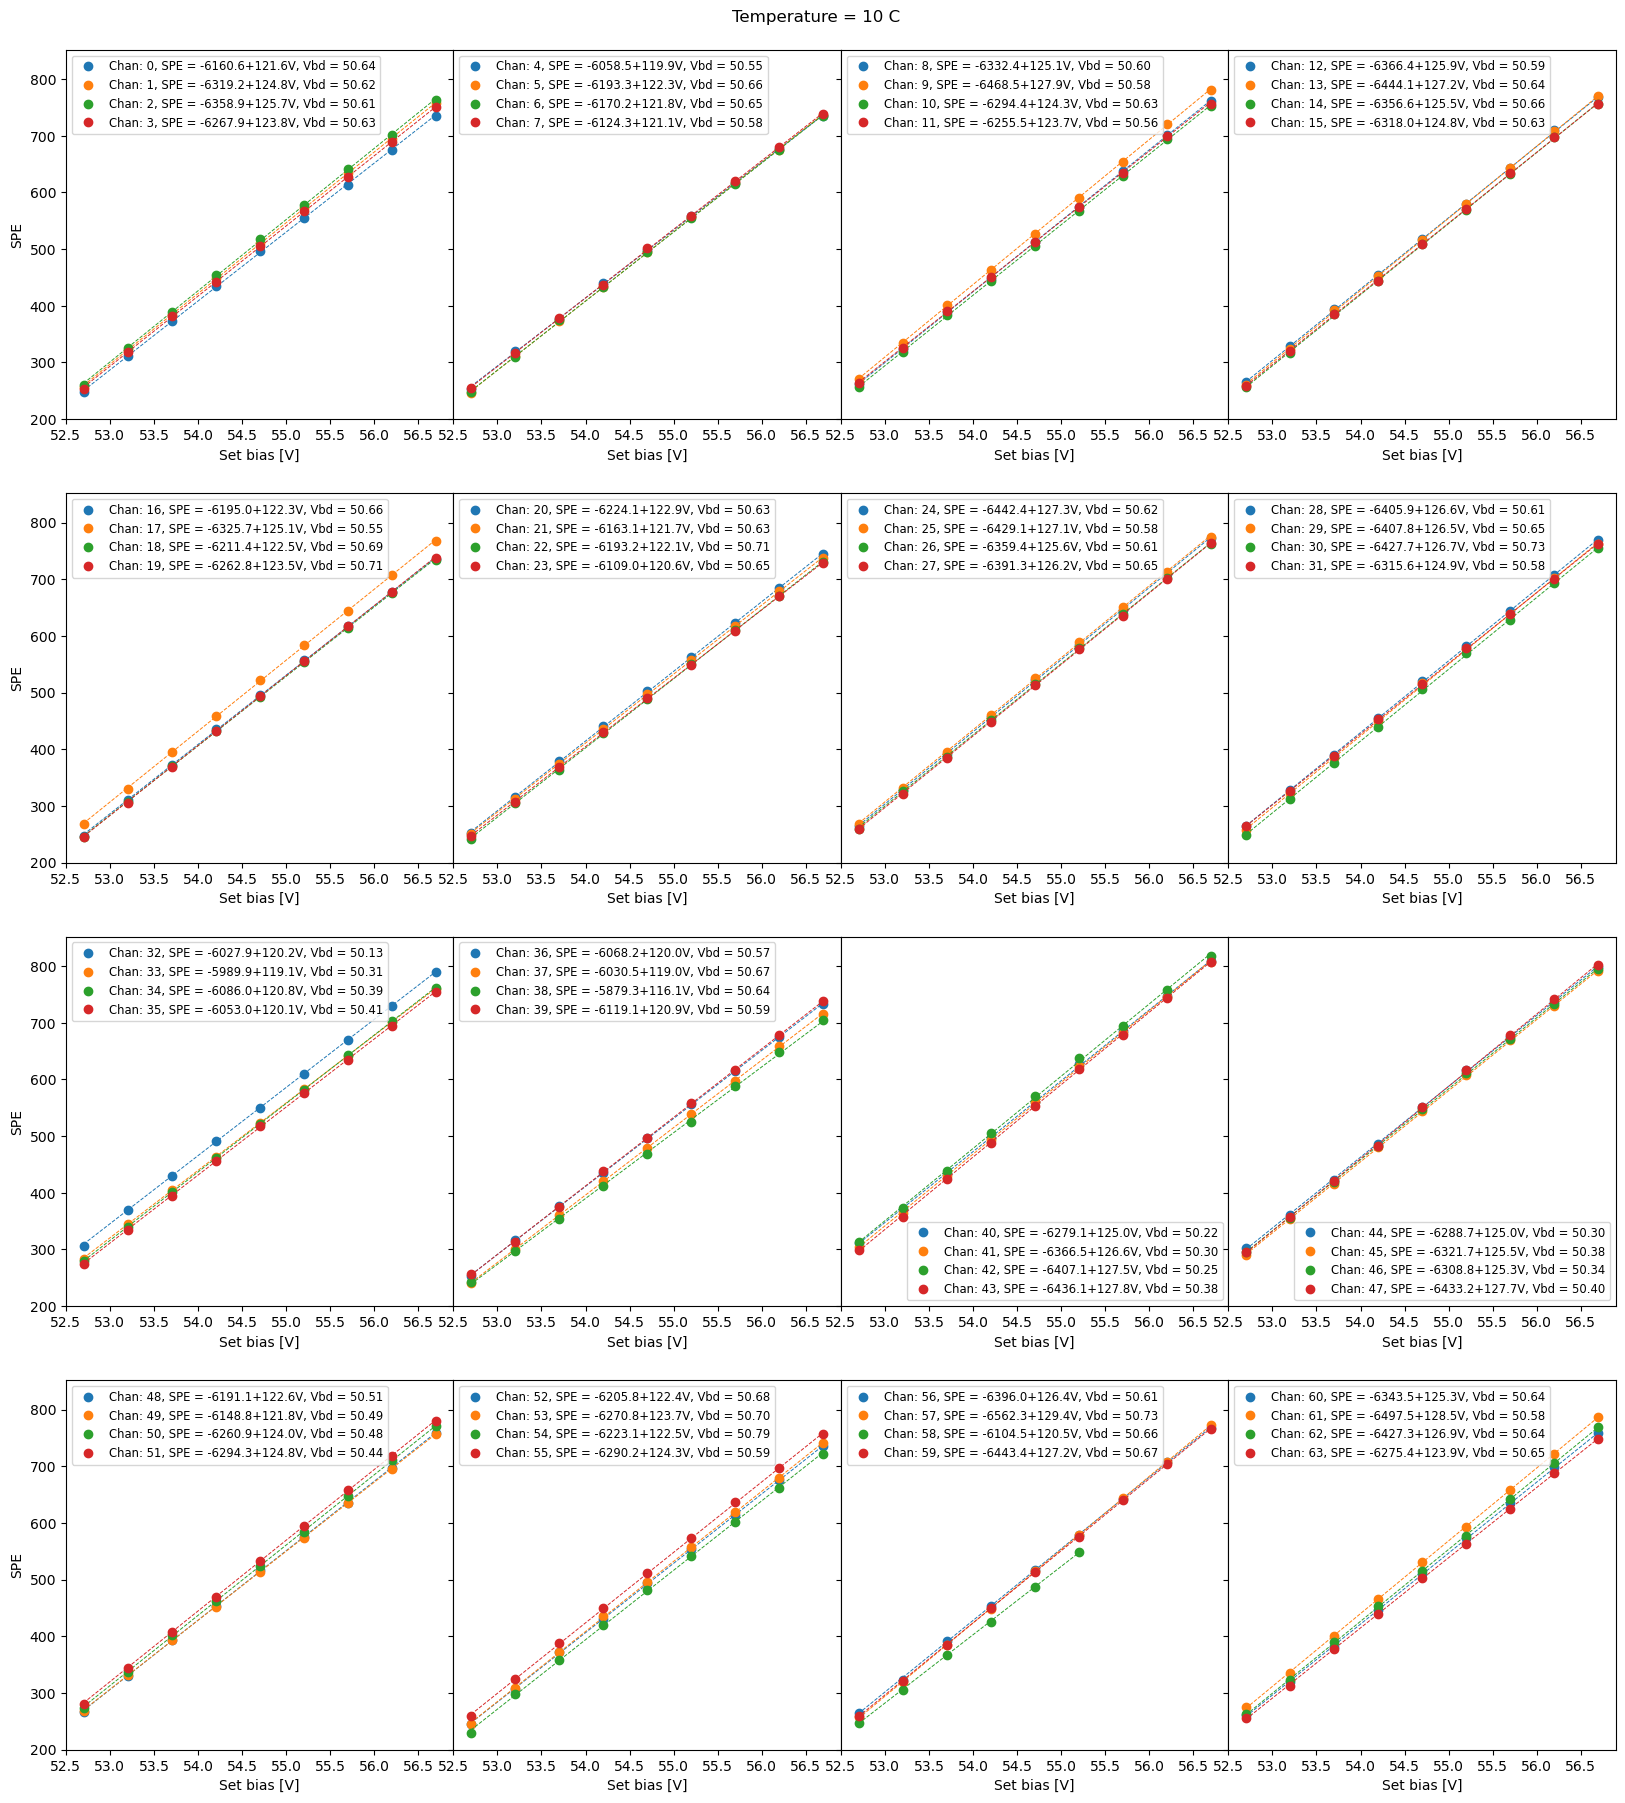

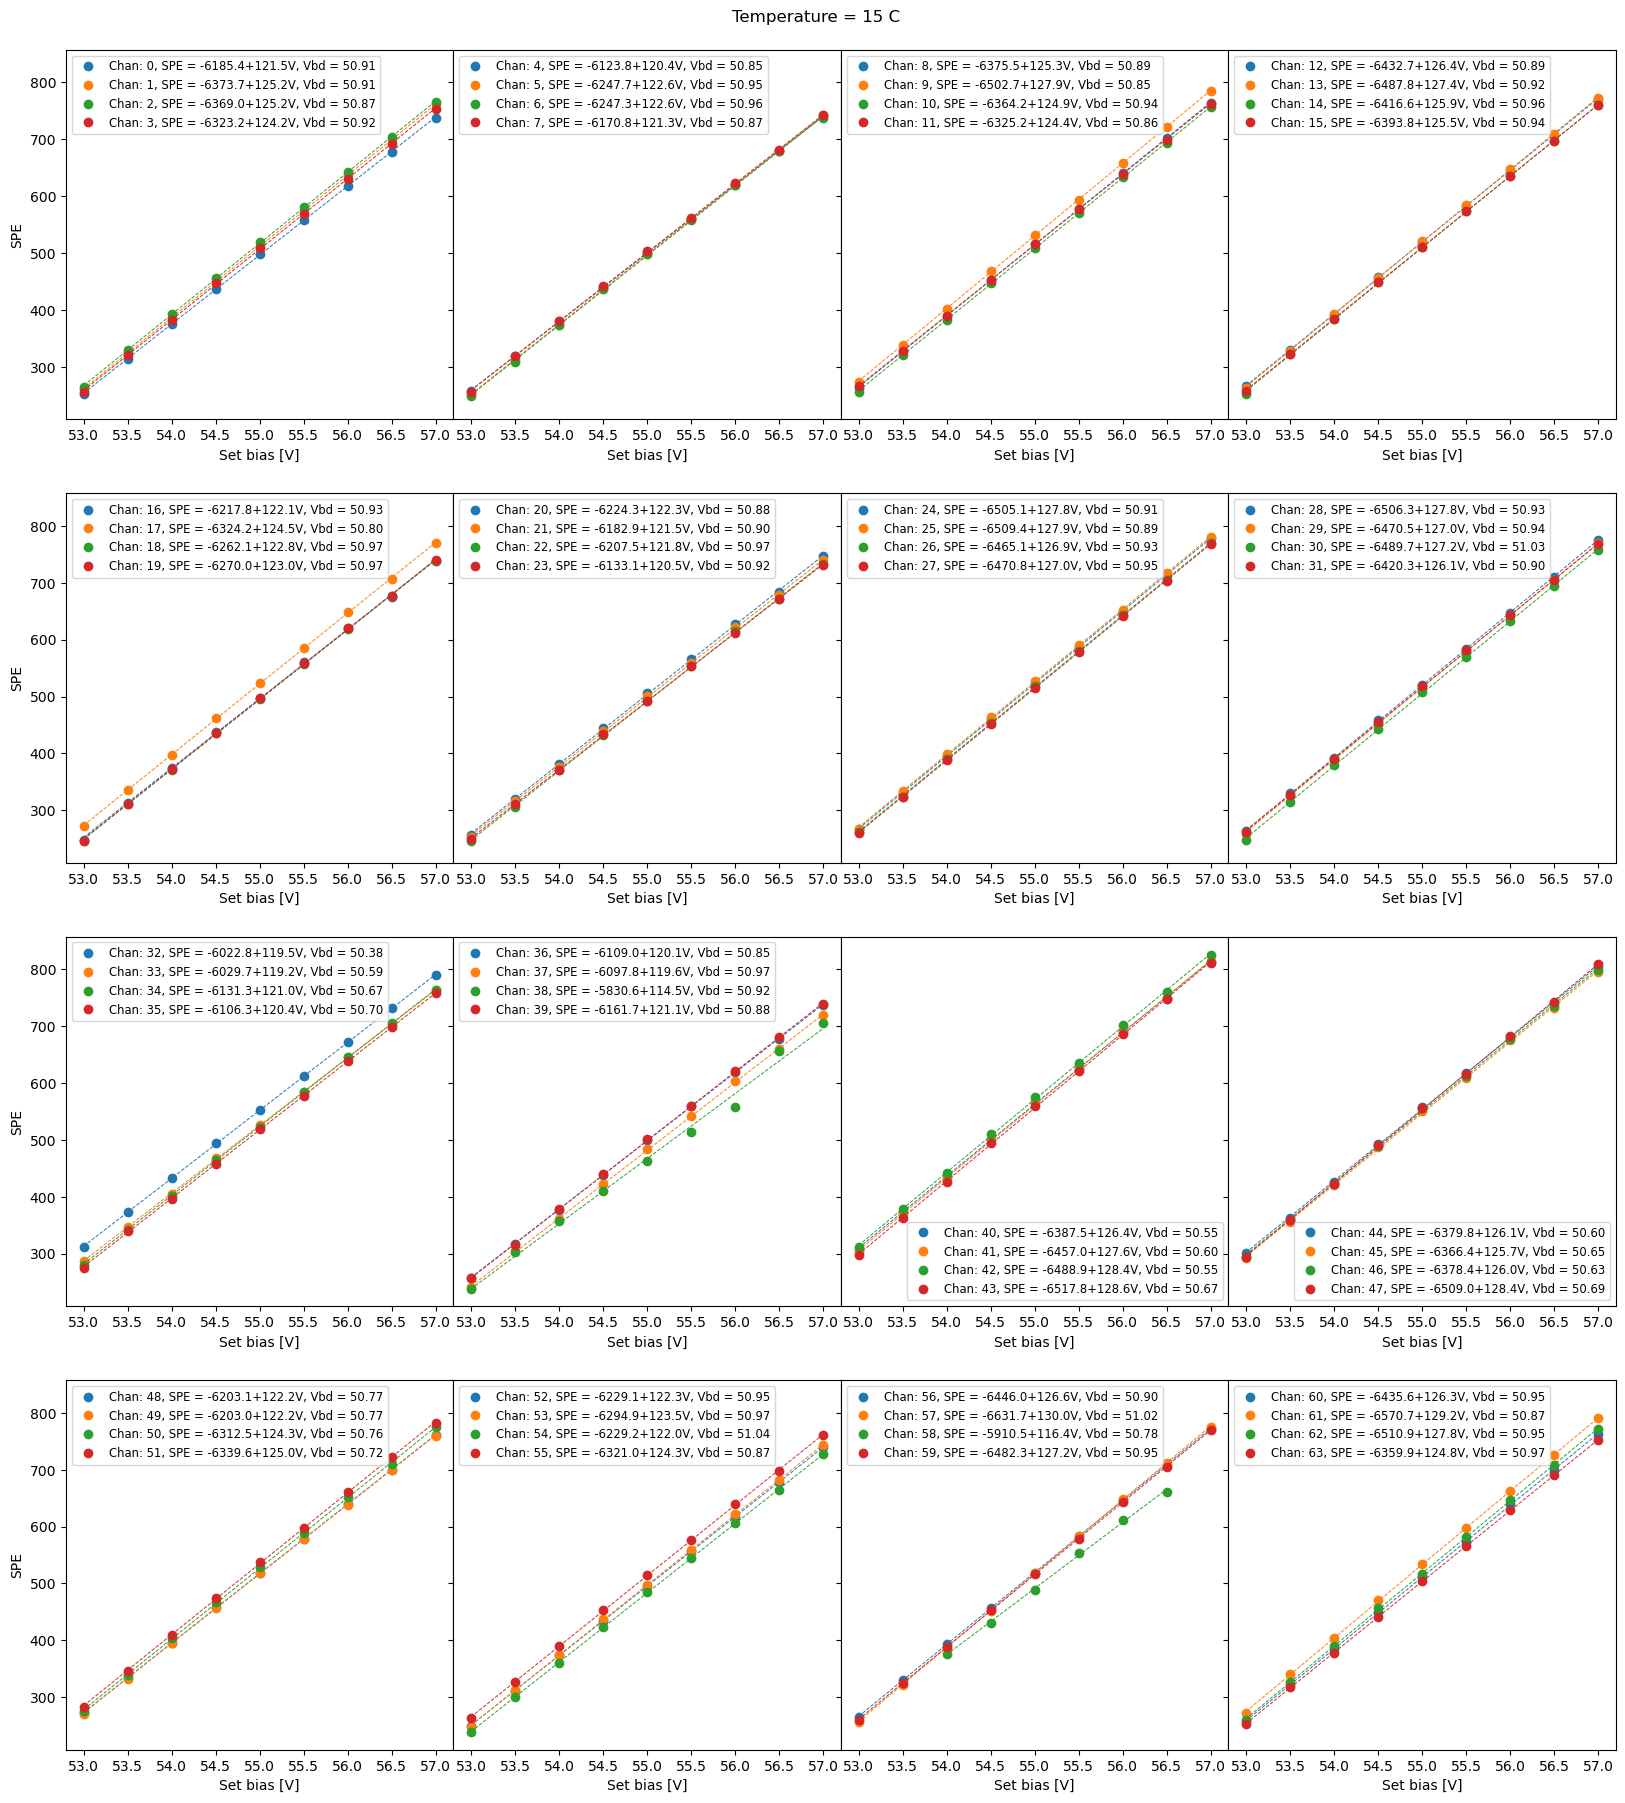

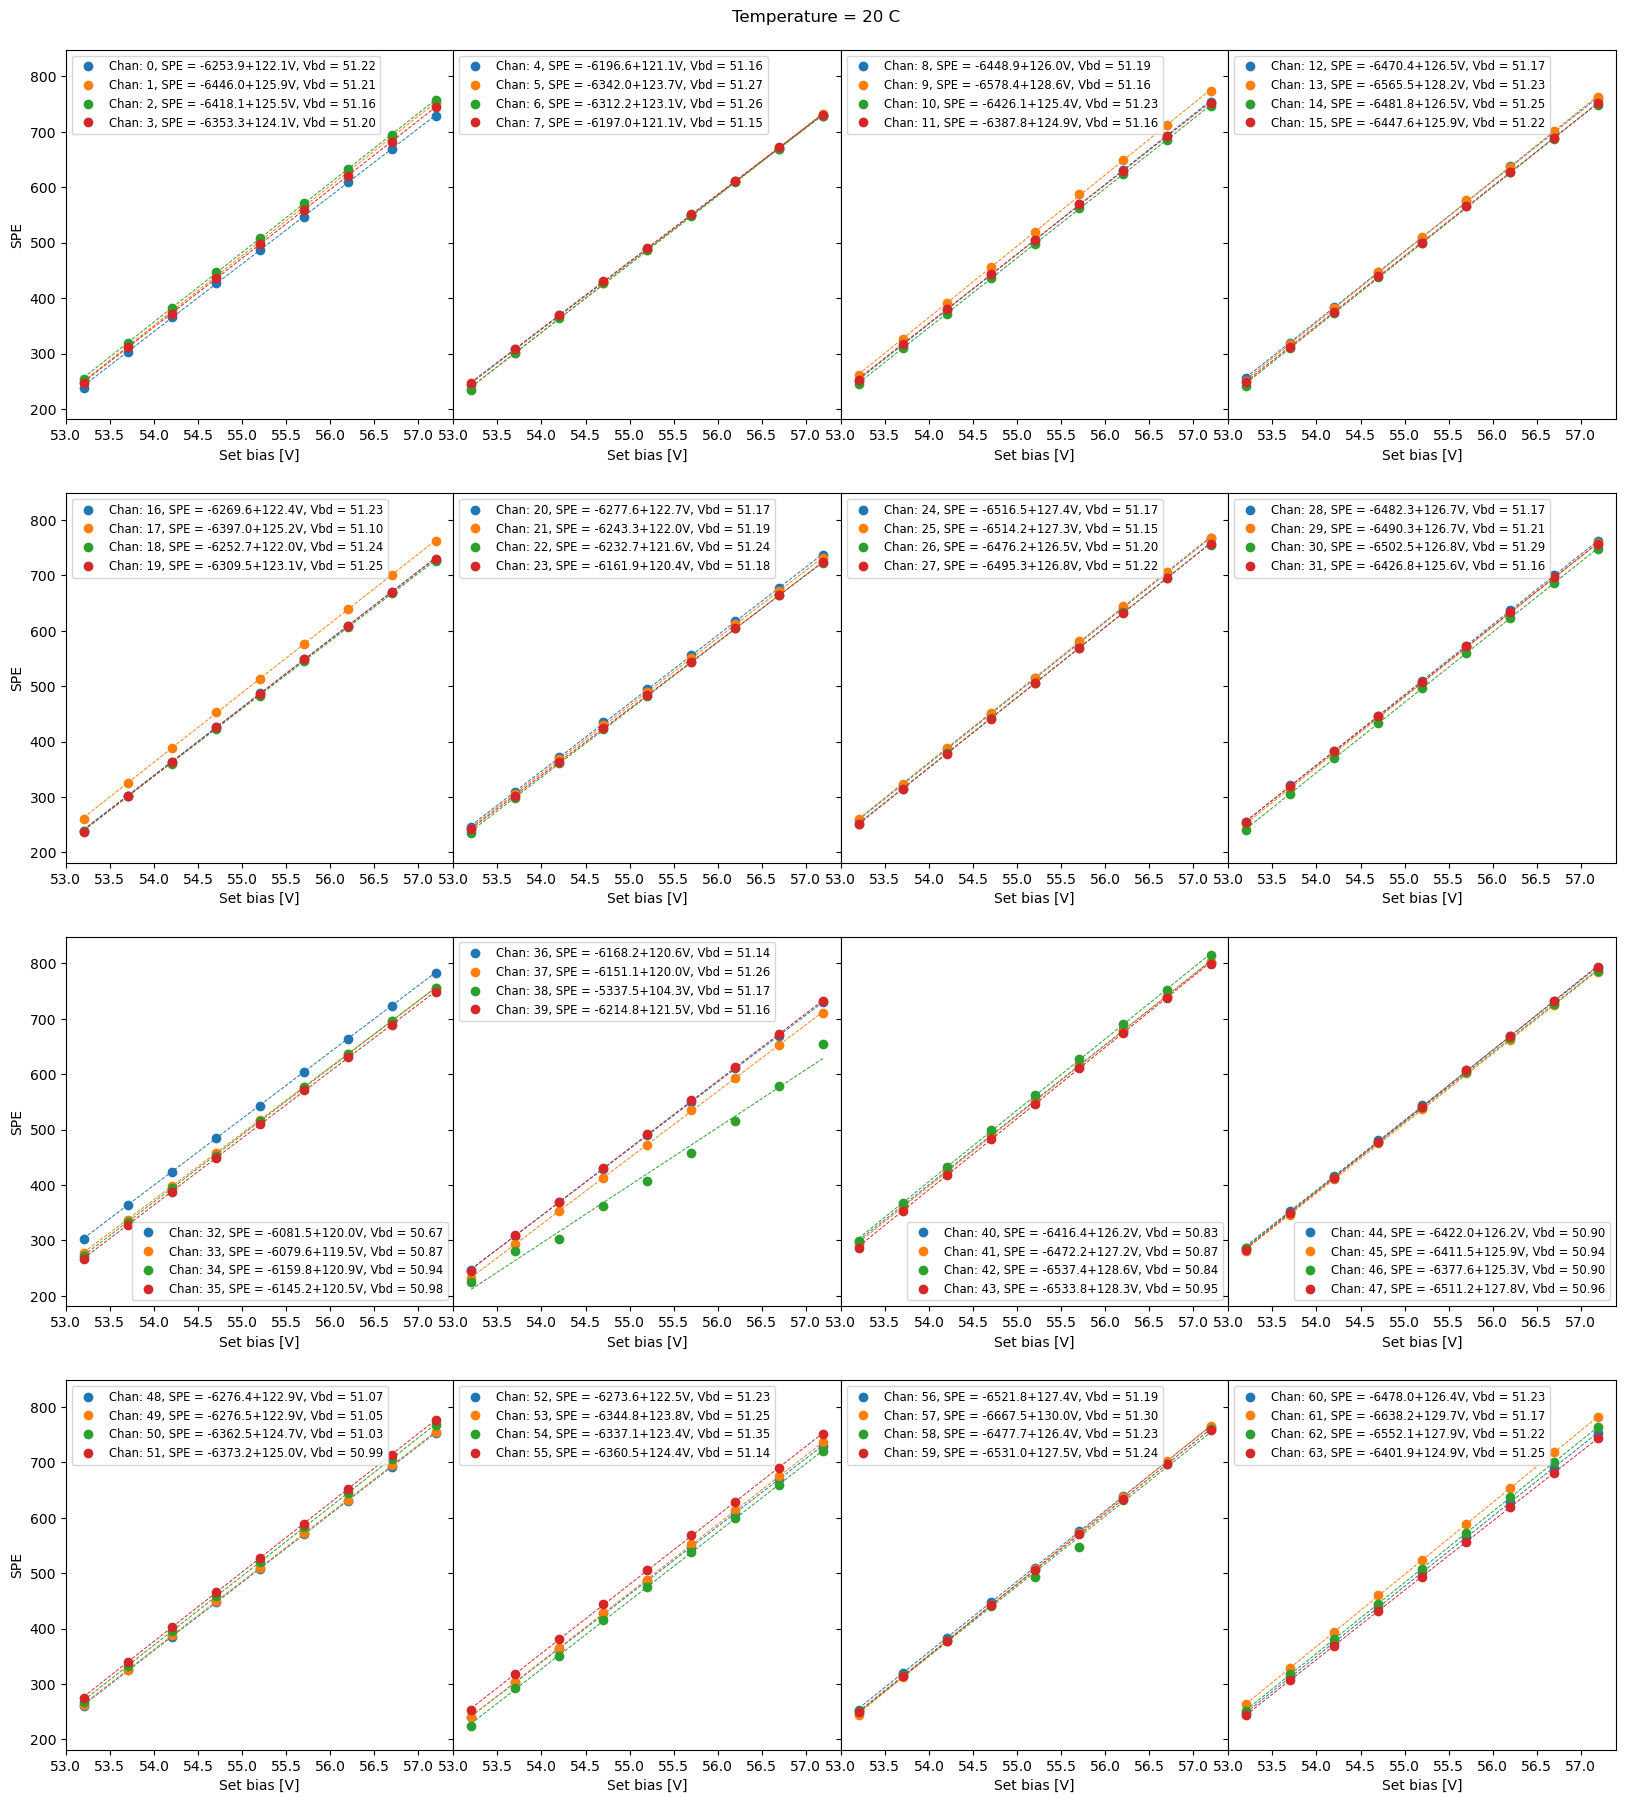

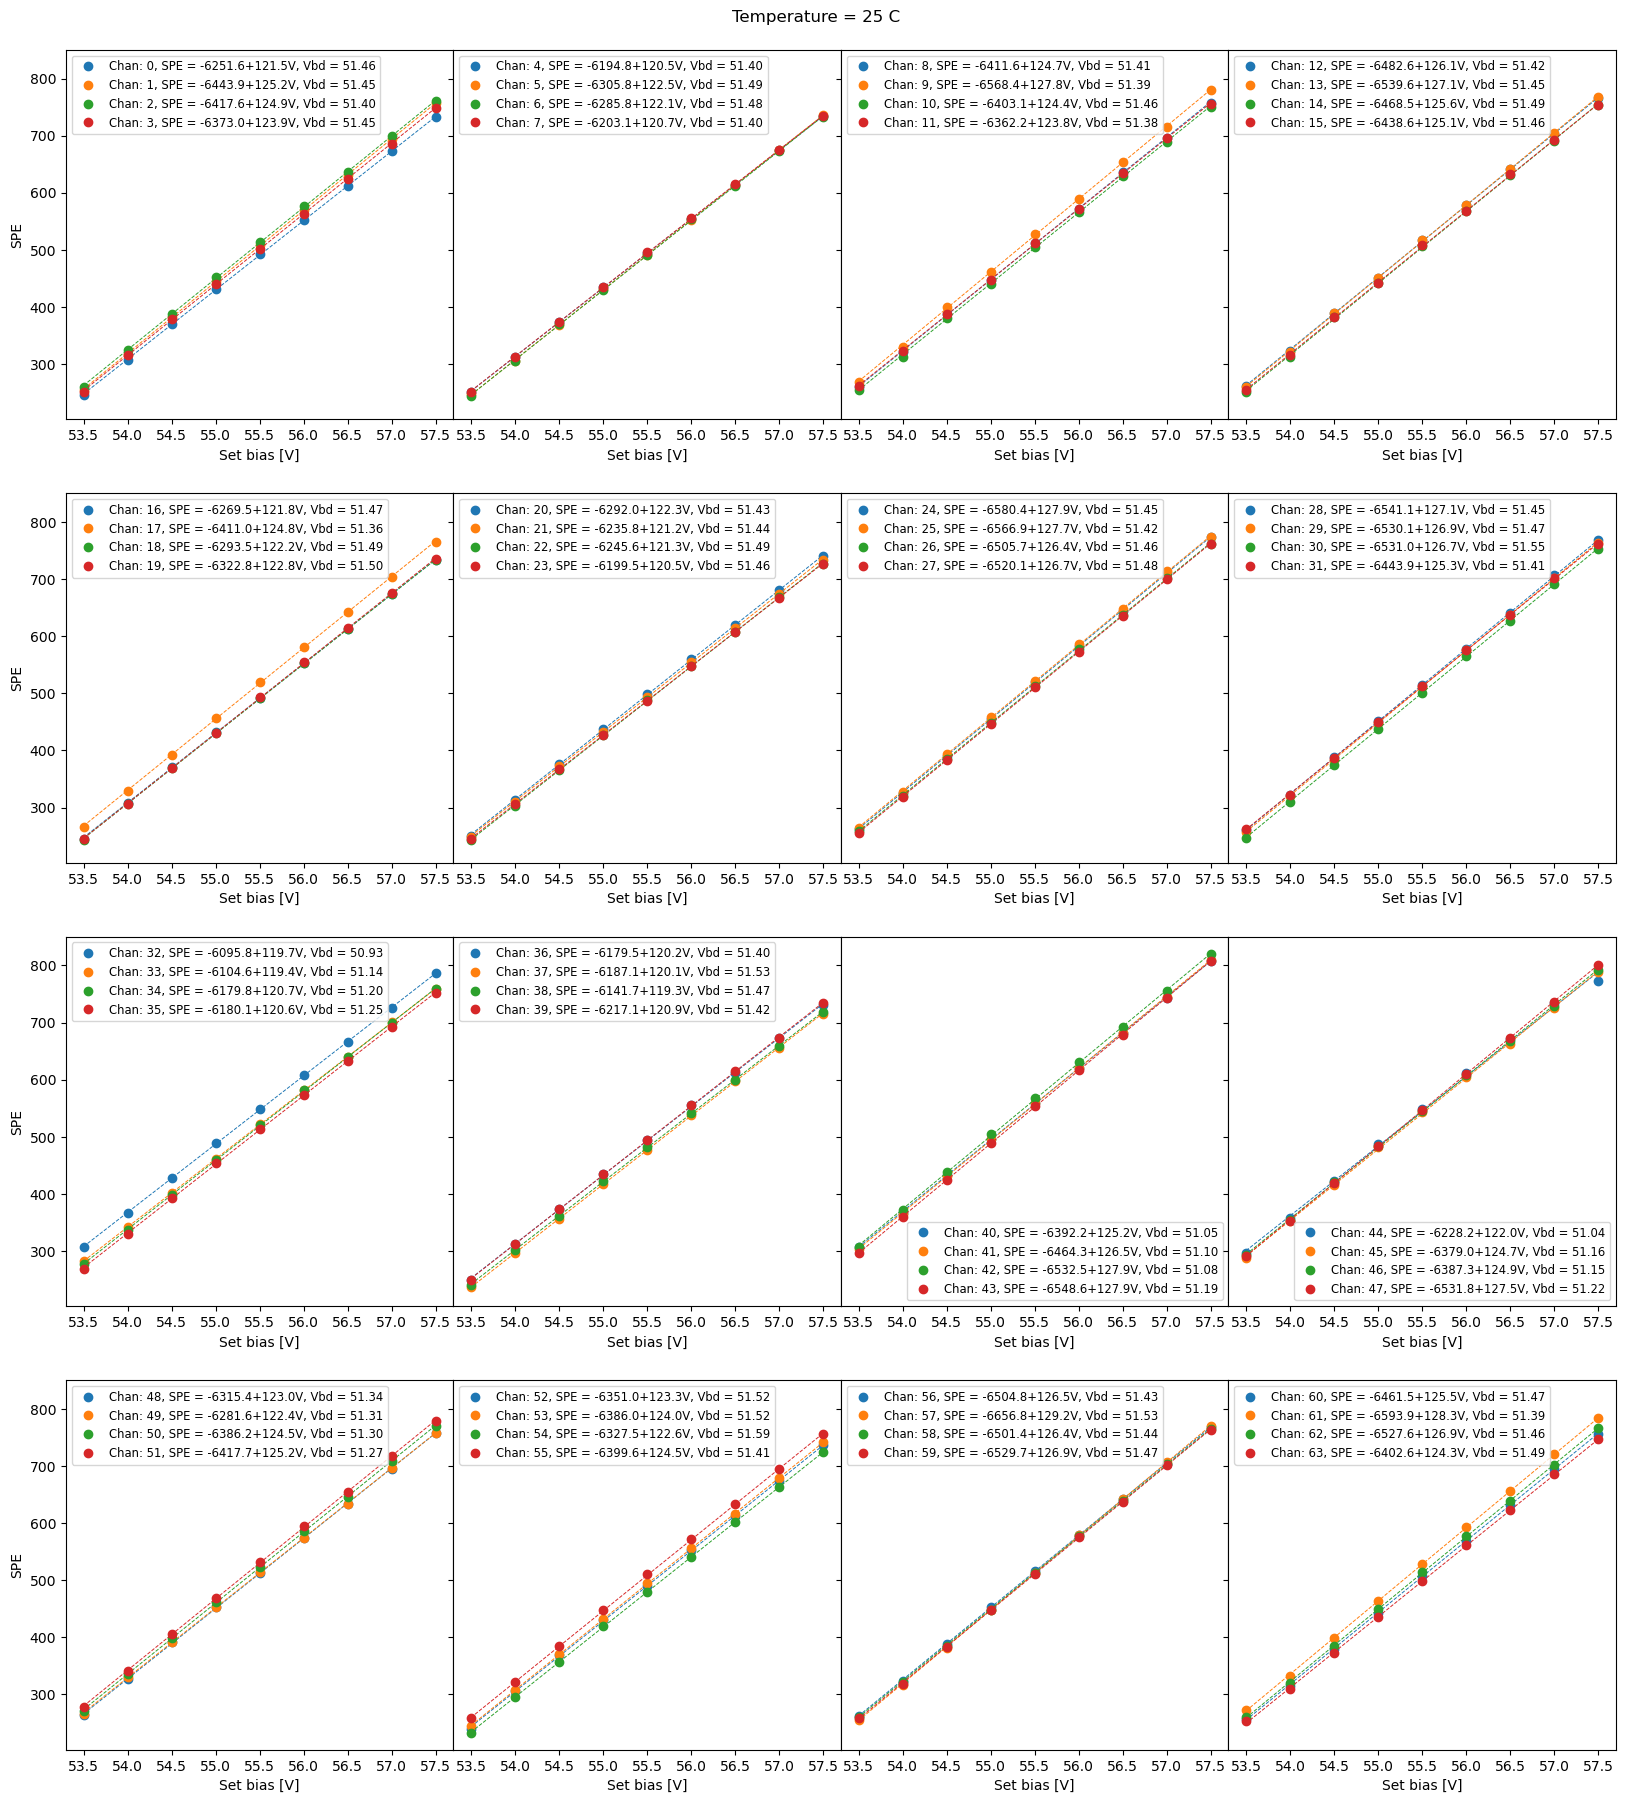

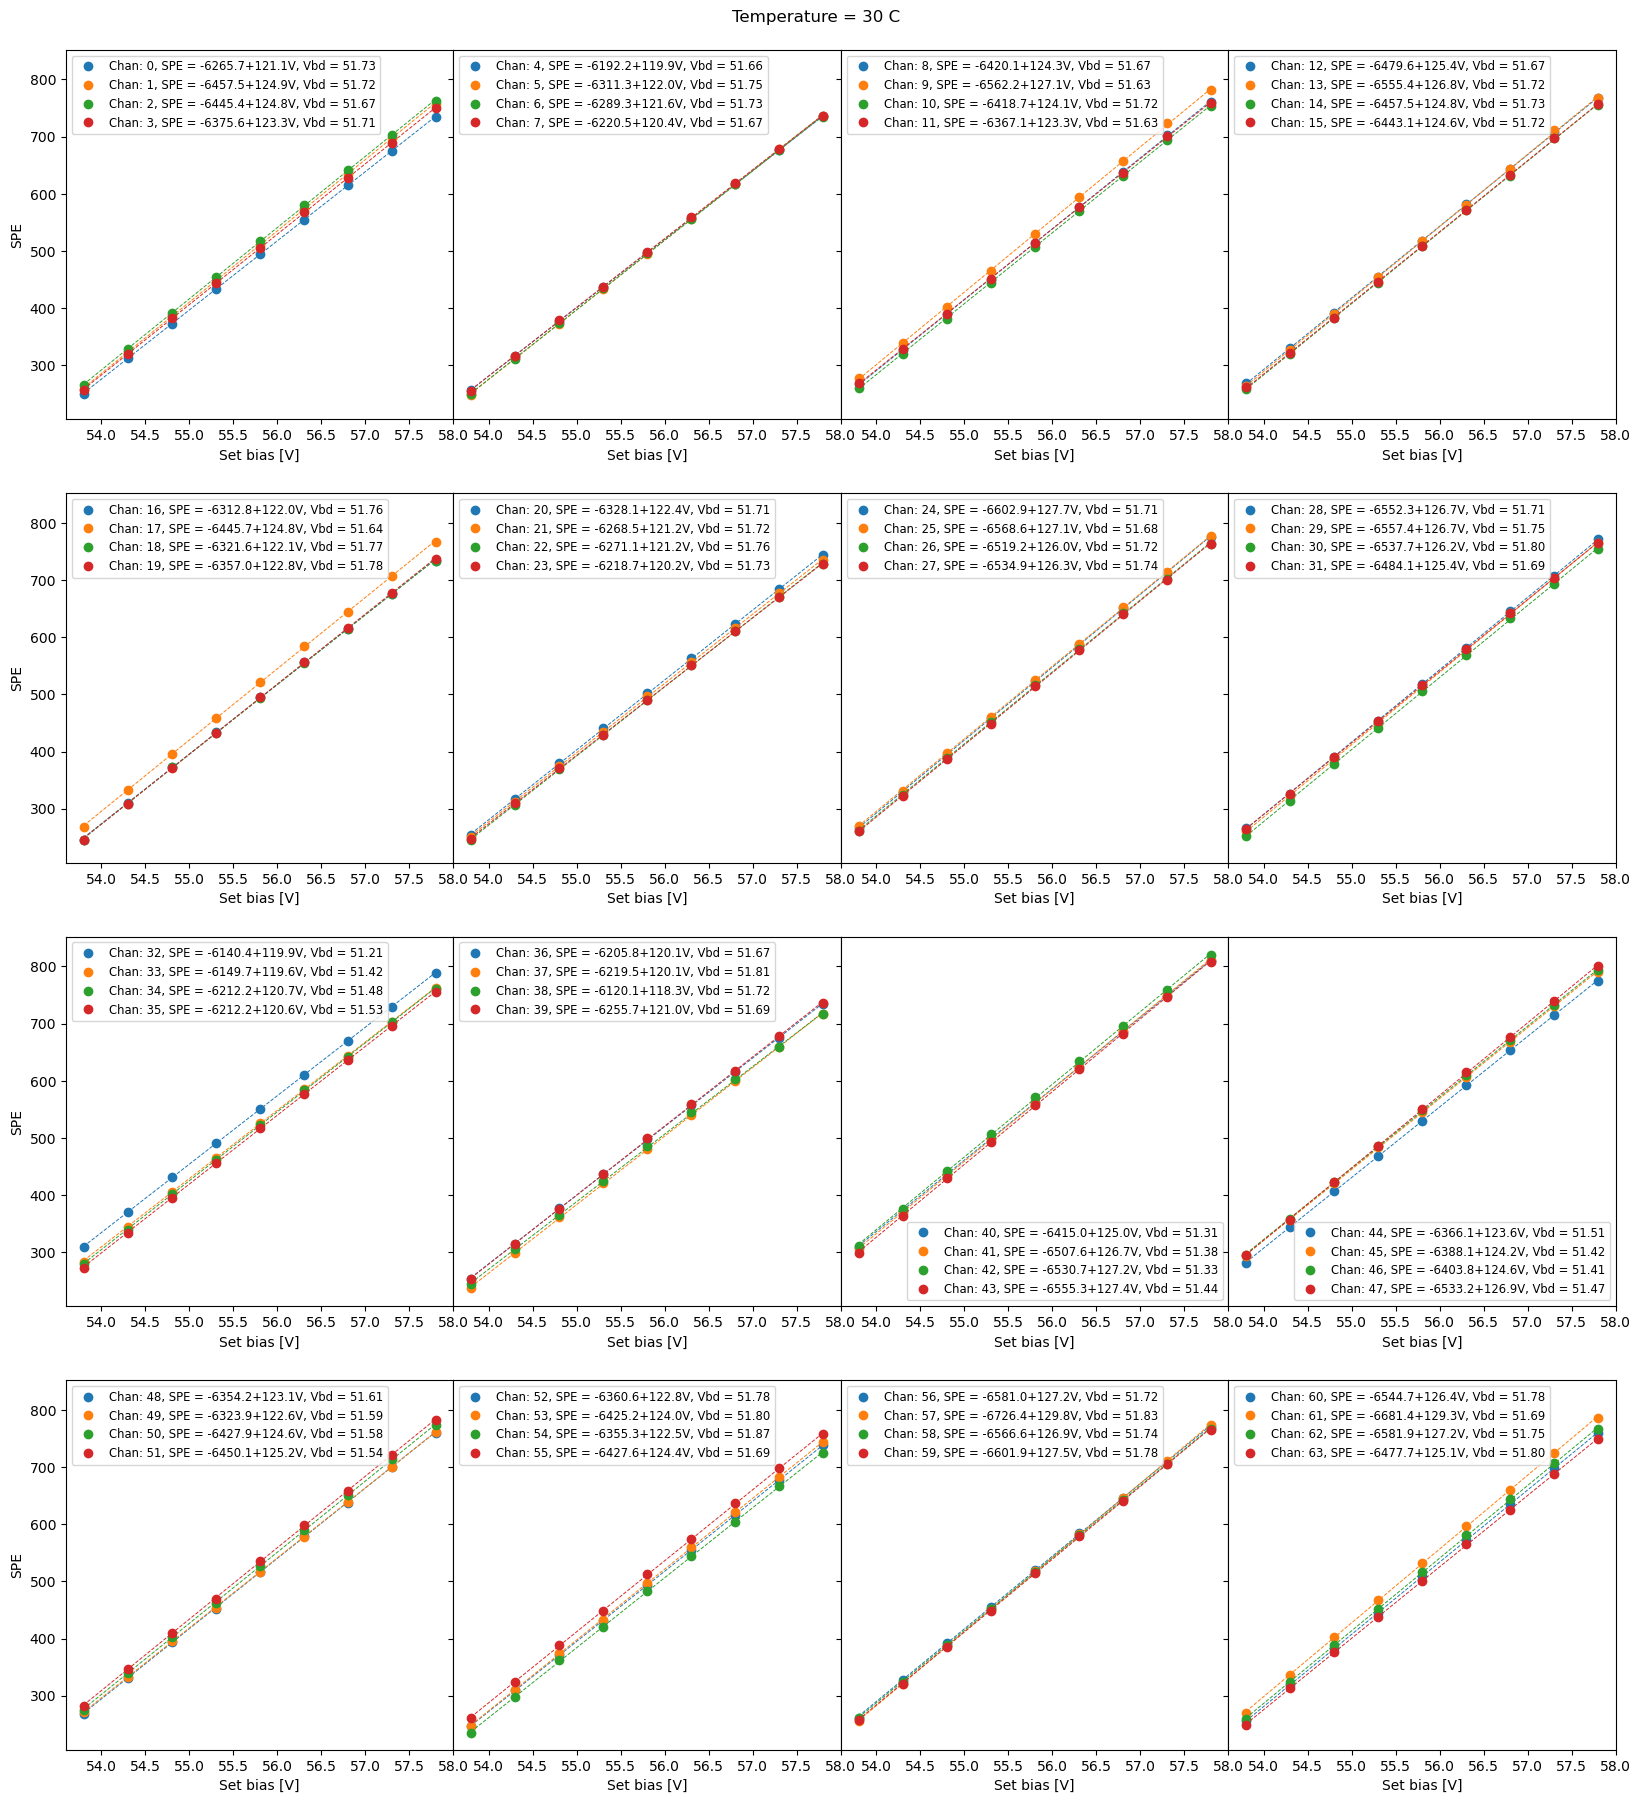

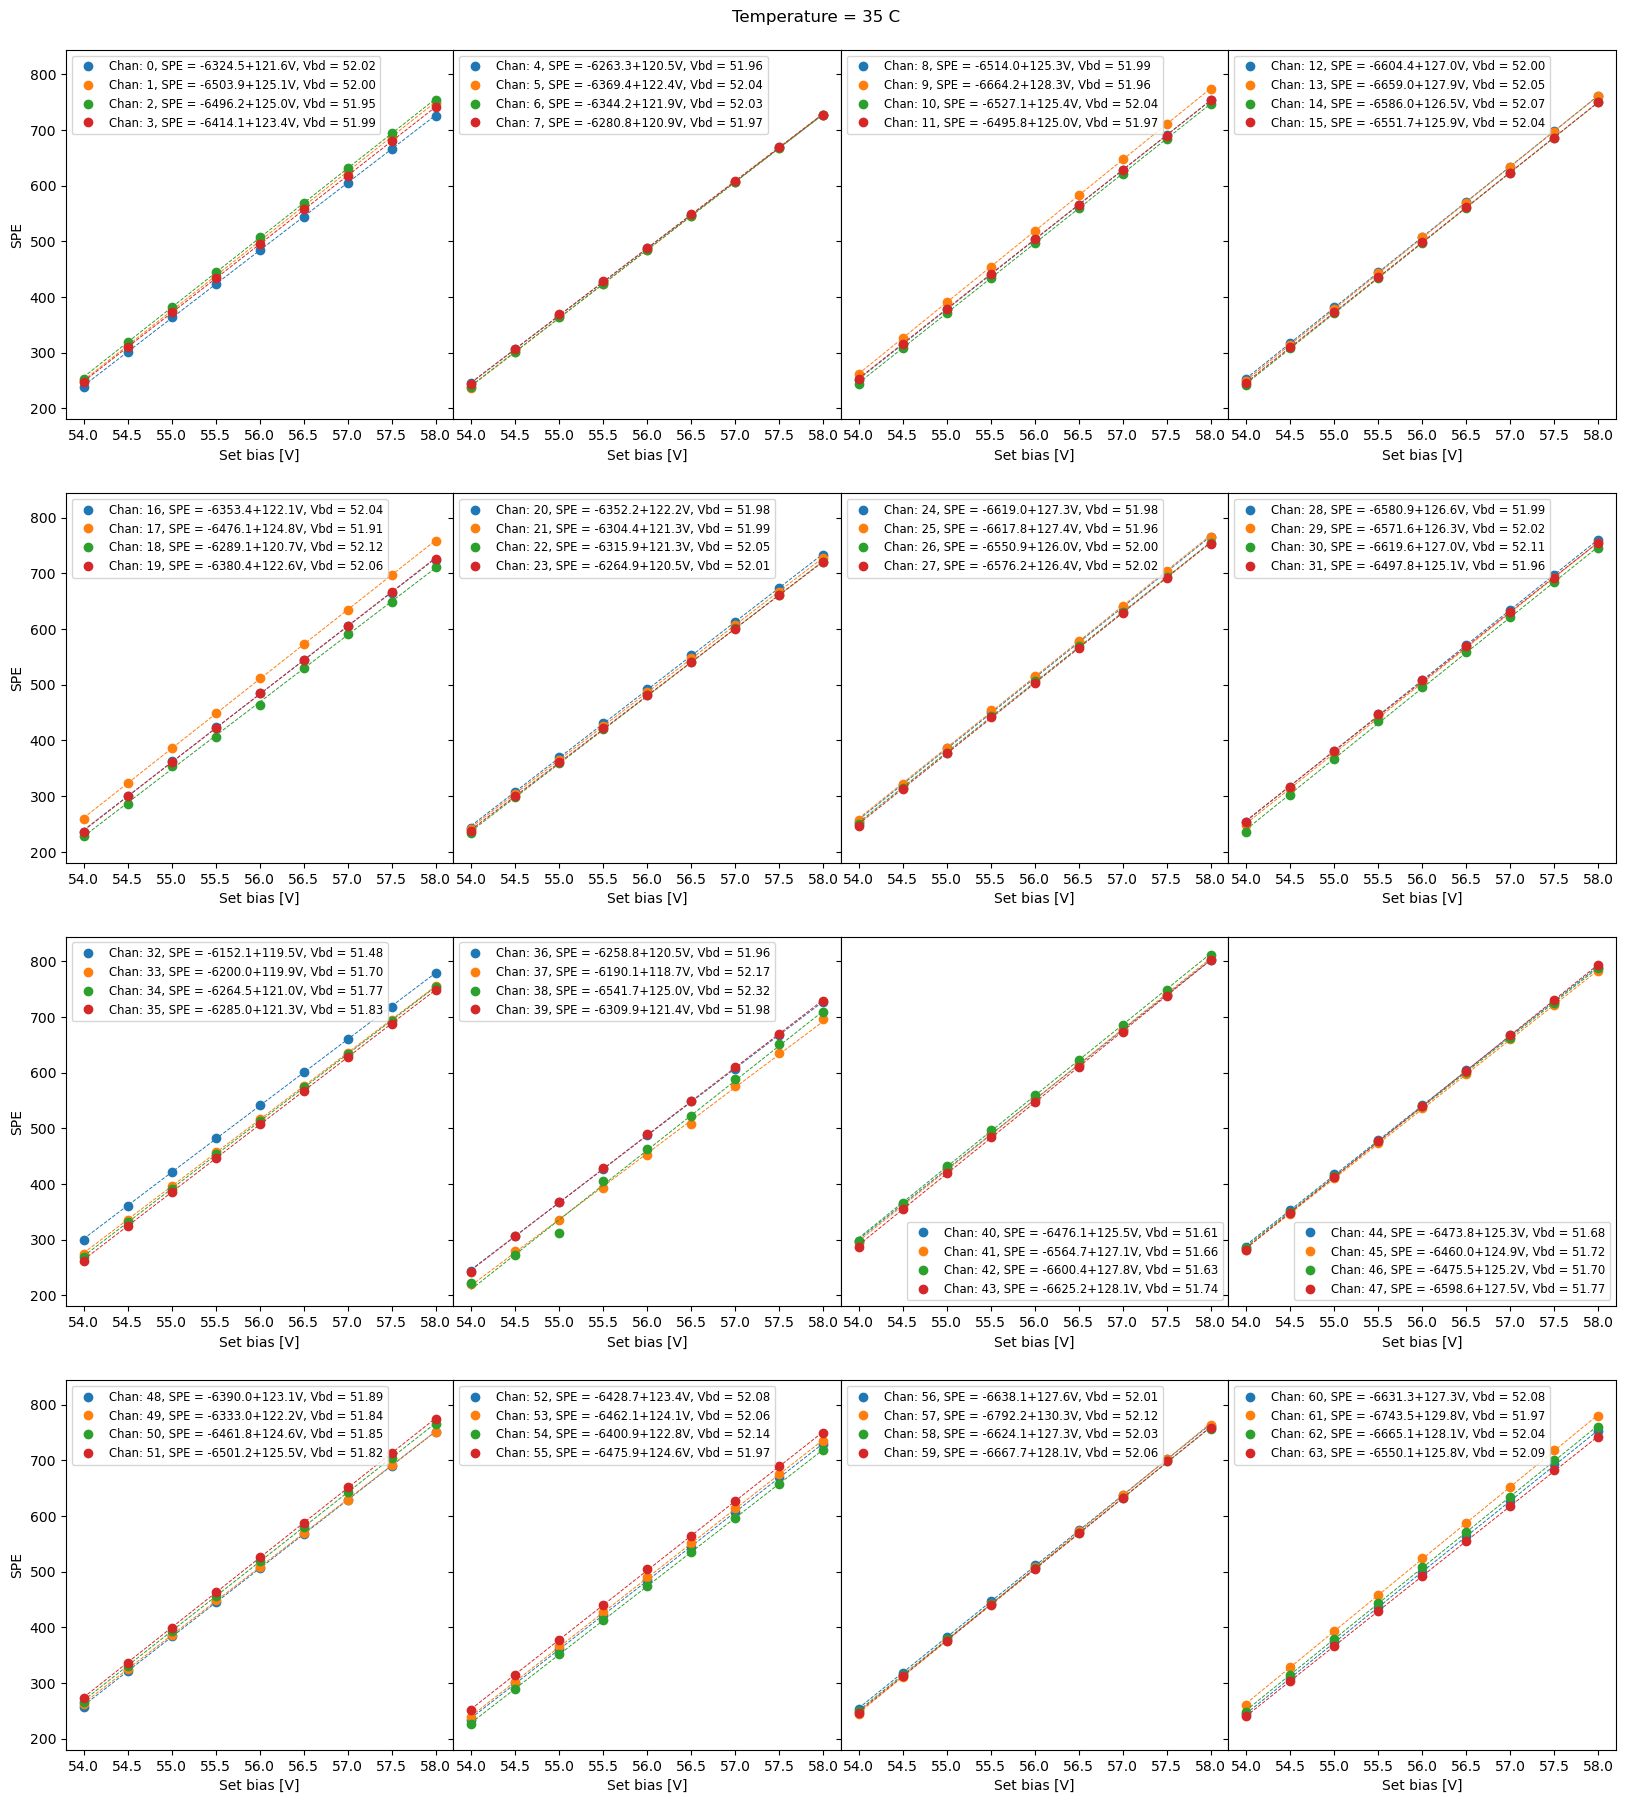

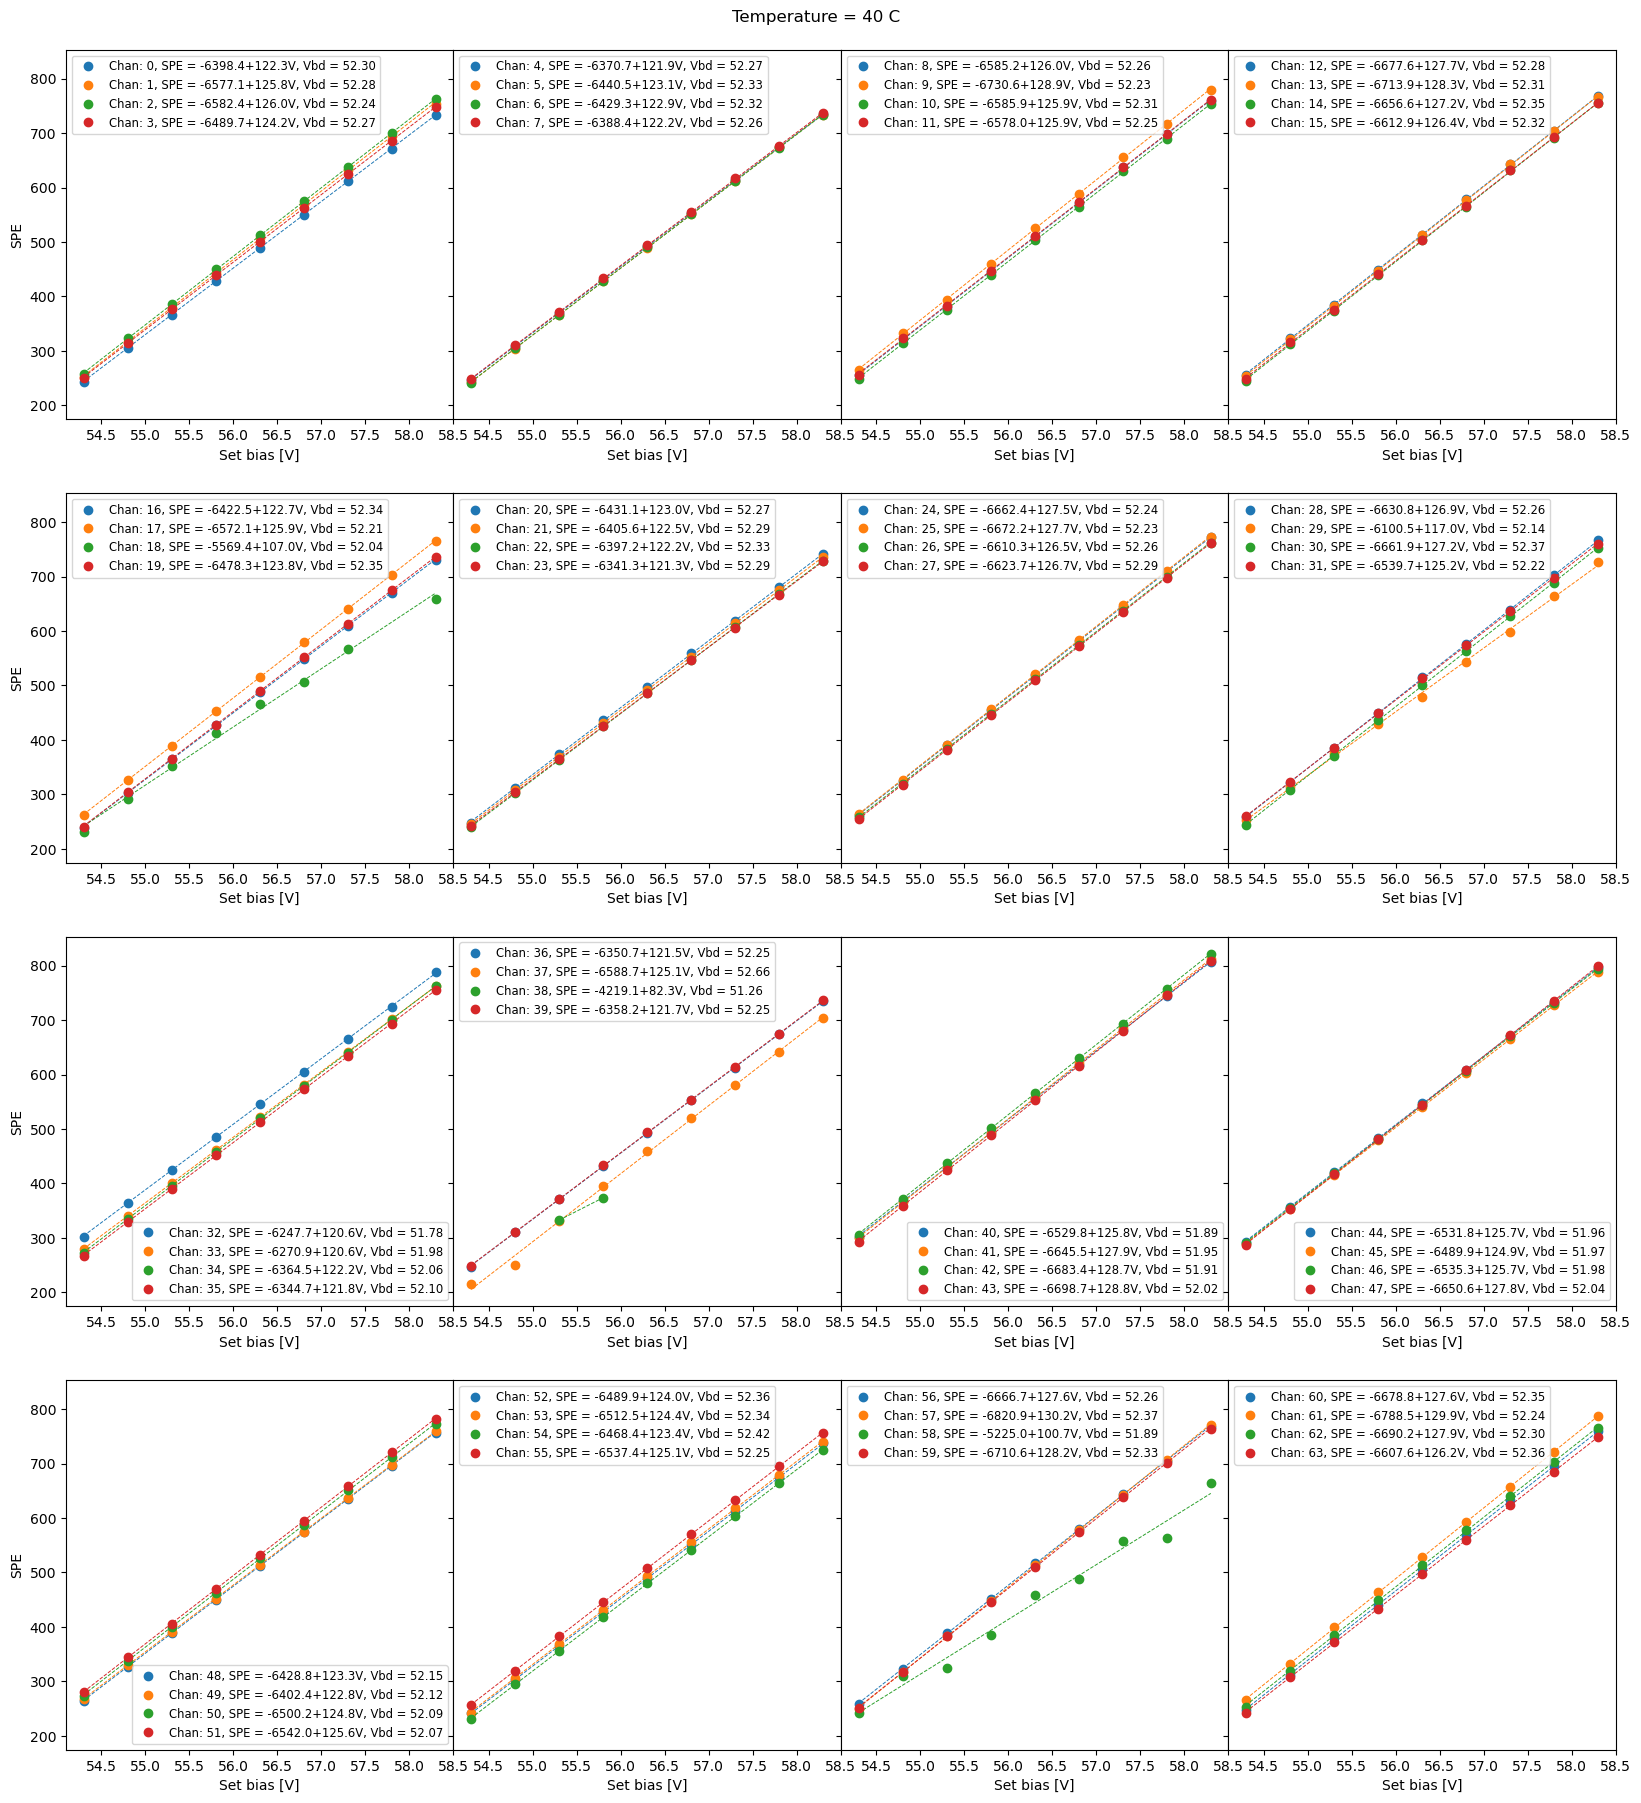

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'calibConstants'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

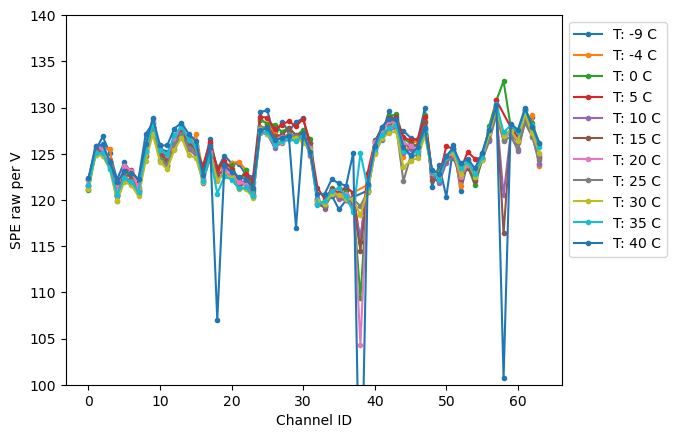

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("SPE raw per V");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(100, 140);

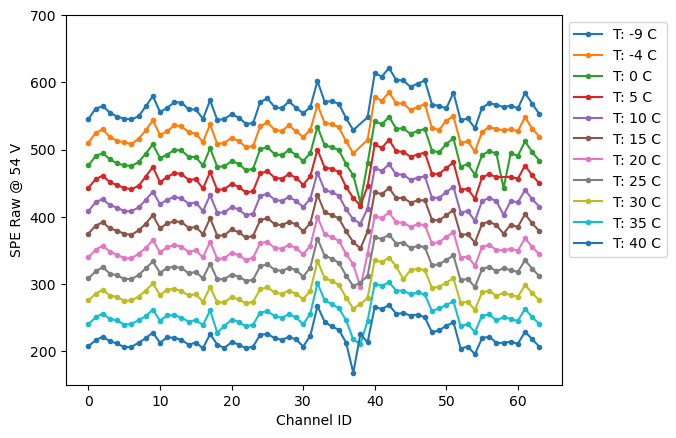

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("SPE Raw @ 54 V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(150, 700);

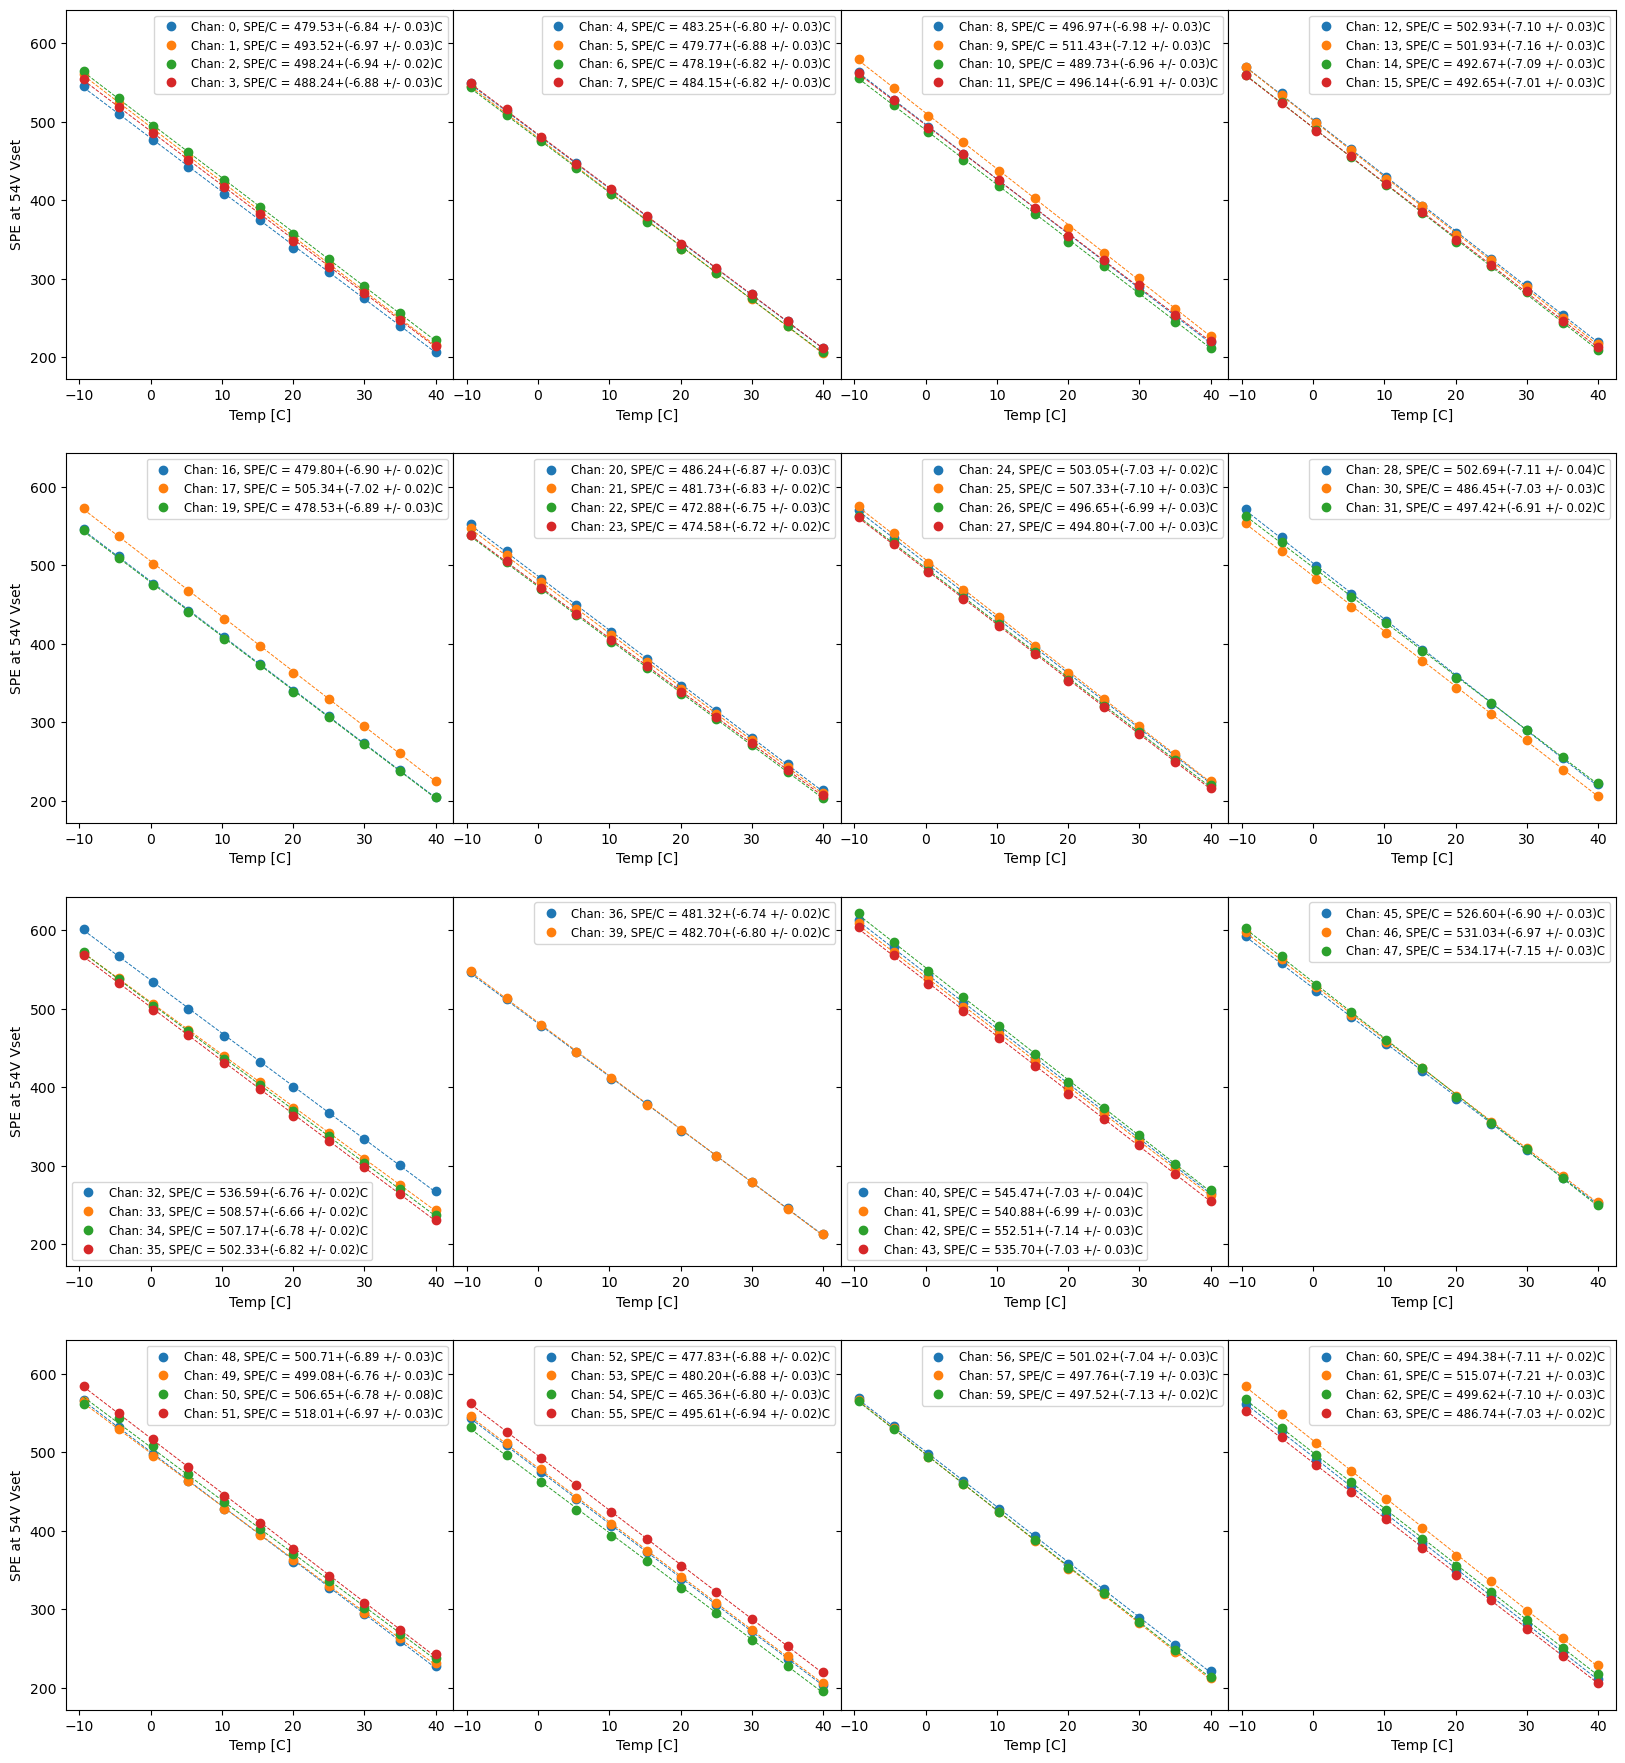

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

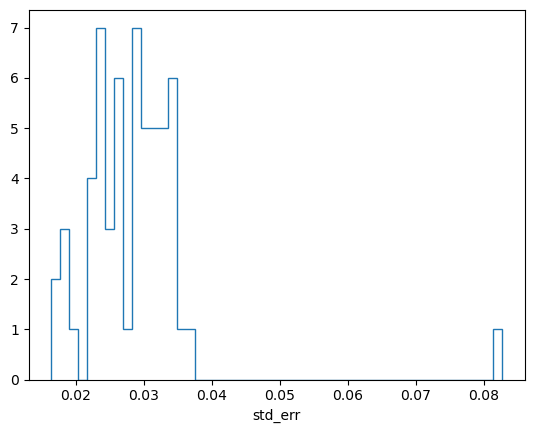

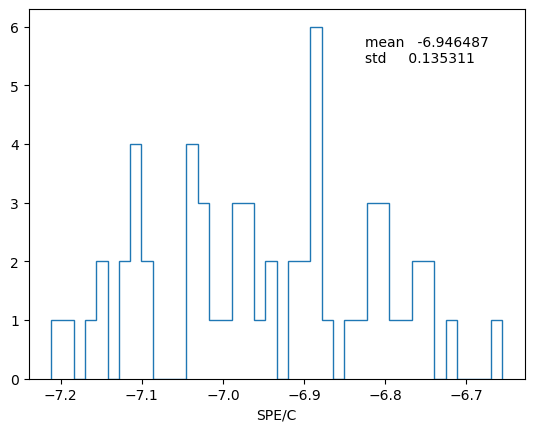

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.3')['slope'], histtype='step', bins=40);
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, dfSPE_Temp['slope'].describe().loc[['mean','std']].to_string());

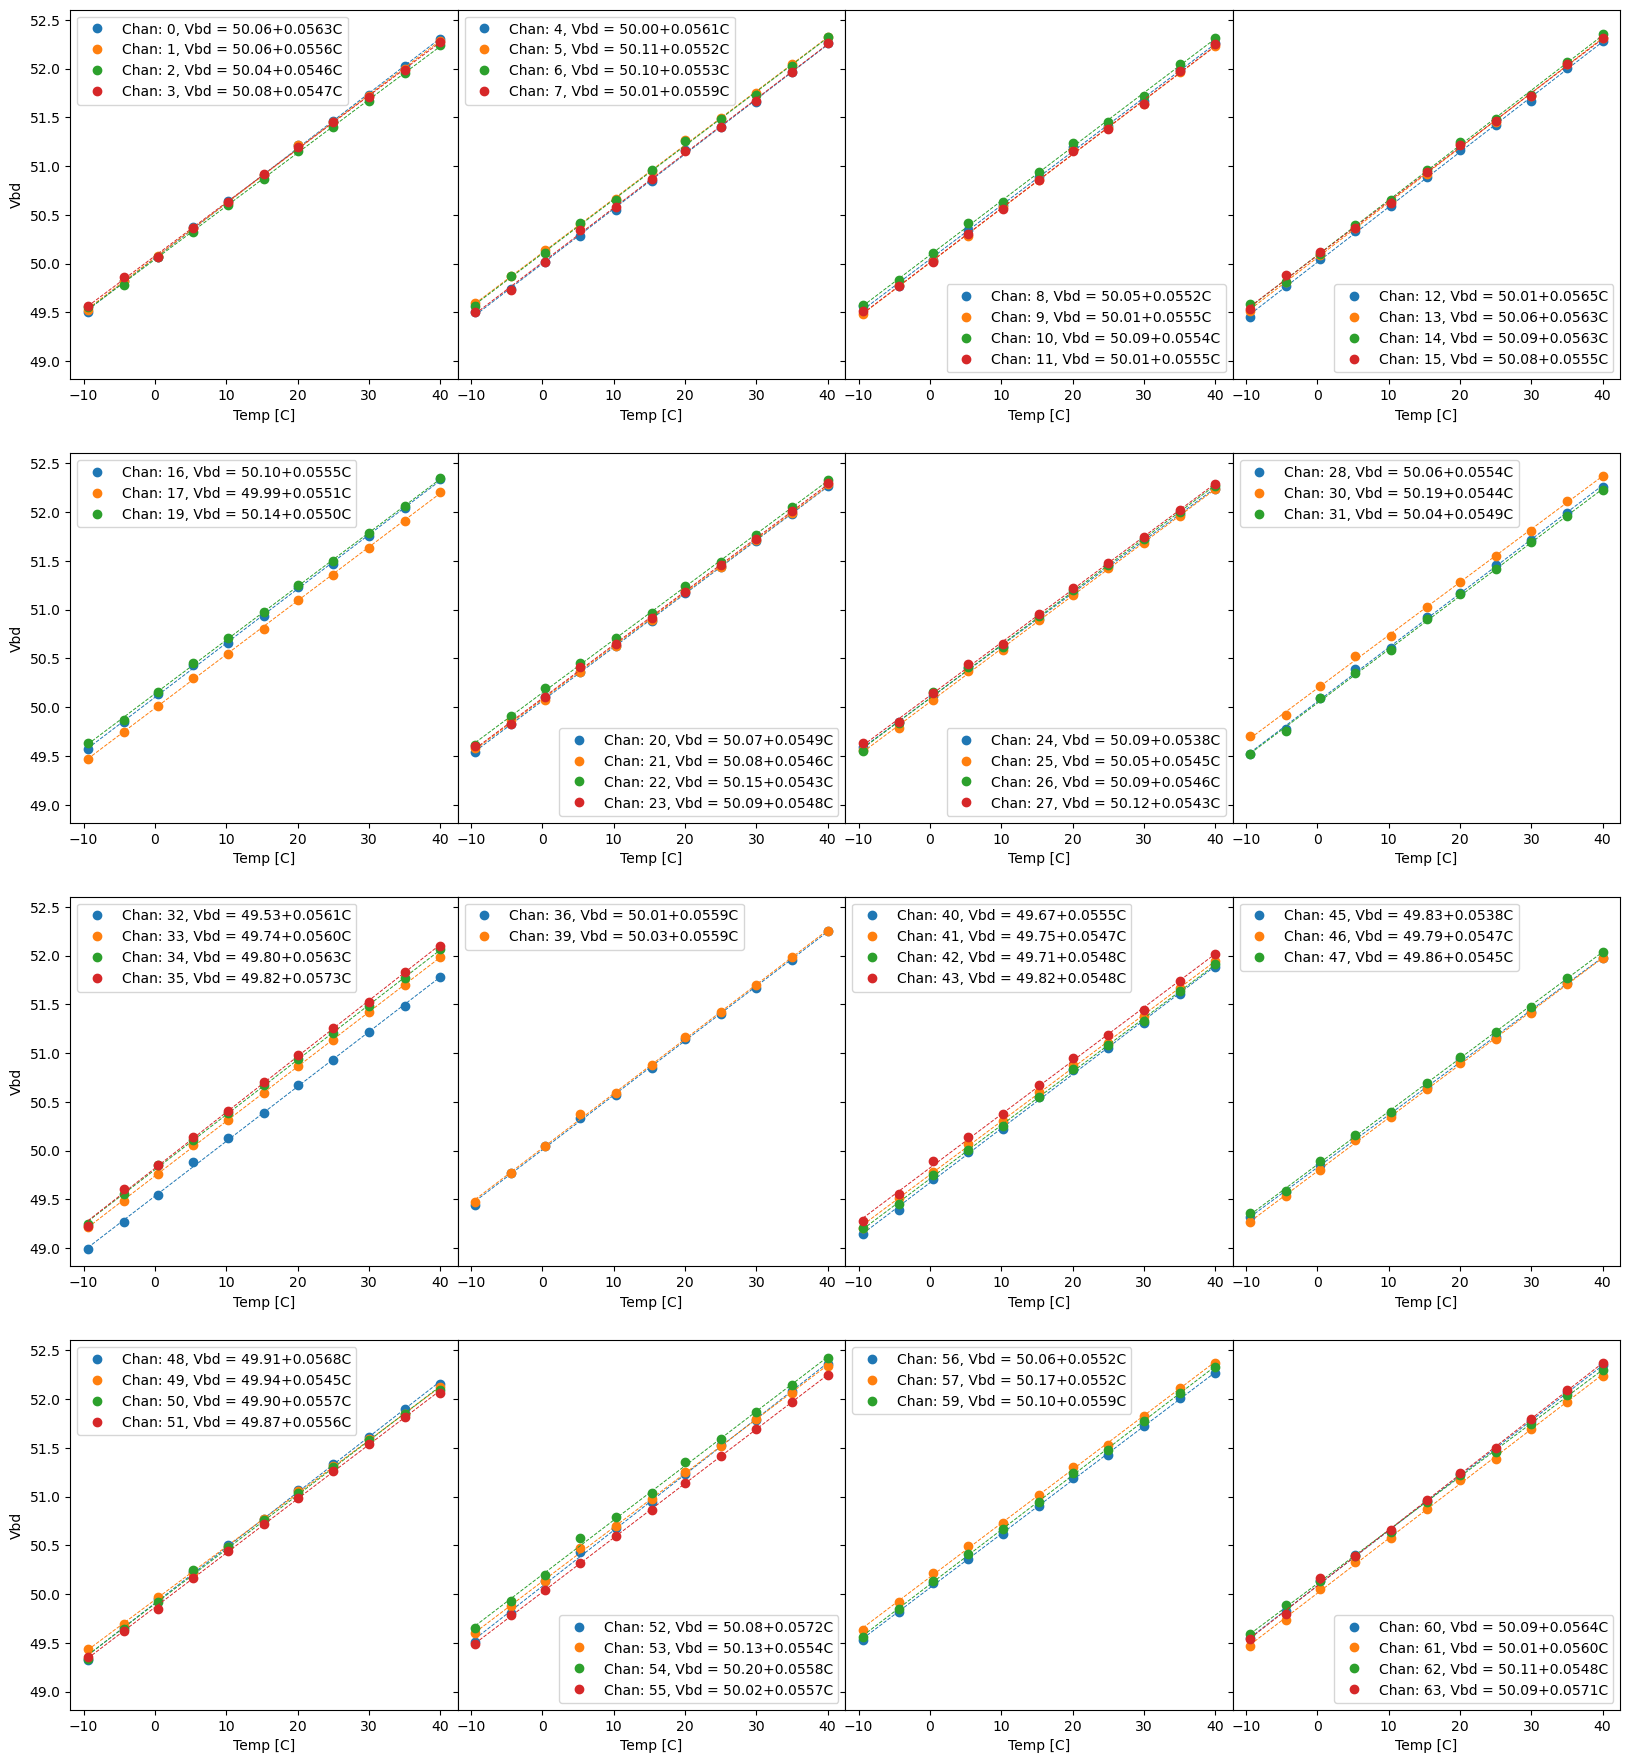

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfVbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        
        if chan in badchannels:
            continue
        
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['Vbd']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
           'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        dfVbd.loc[len(dfVbd)] = new_row
        ax.legend()

Text(0.65, 0.65, 'mean    55.404083\nstd      0.806070')

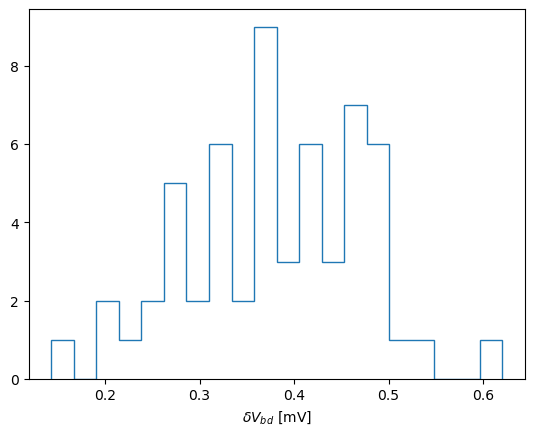

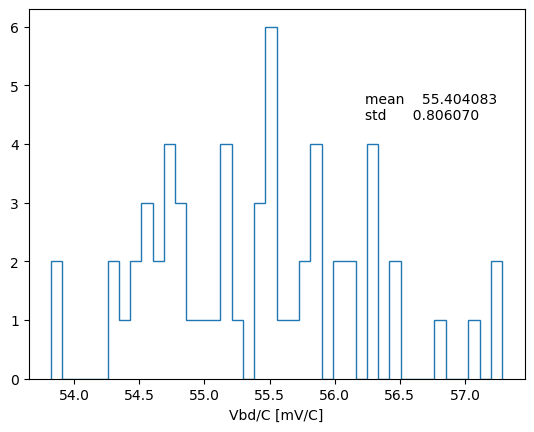

In [9]:
plt.hist(dfVbd['std_err'], histtype='step', bins=20)
plt.xlabel("$\delta V_{bd}$ [mV]")
plt.figure()

var = dfVbd.query('std_err<5')['slope']
plt.hist(var, histtype='step', bins=40);
plt.xlabel("Vbd/C [mV/C]")
plt.figtext(0.65,0.65, dfVbd['slope'].describe().loc[['mean','std']].to_string())

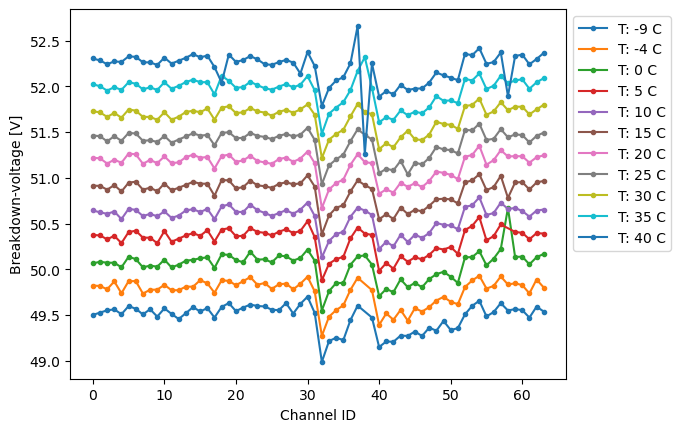

In [10]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['Vbd'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("Breakdown-voltage [V]");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

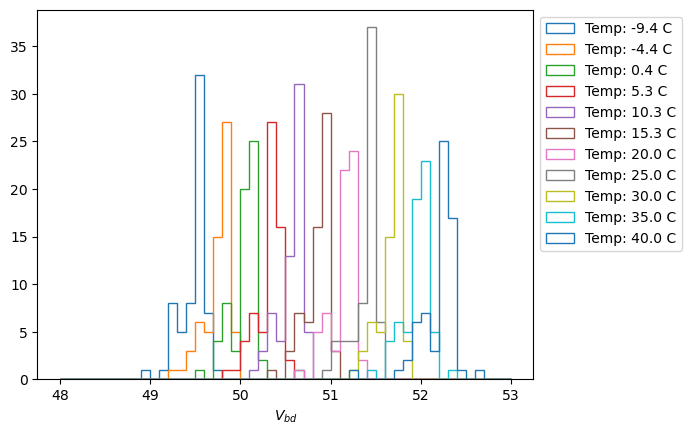

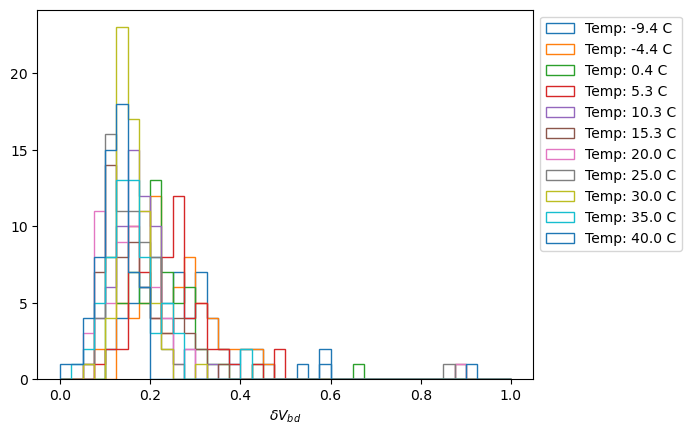

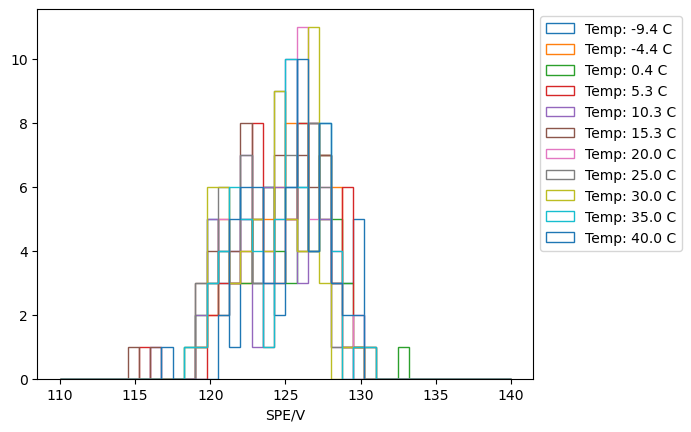

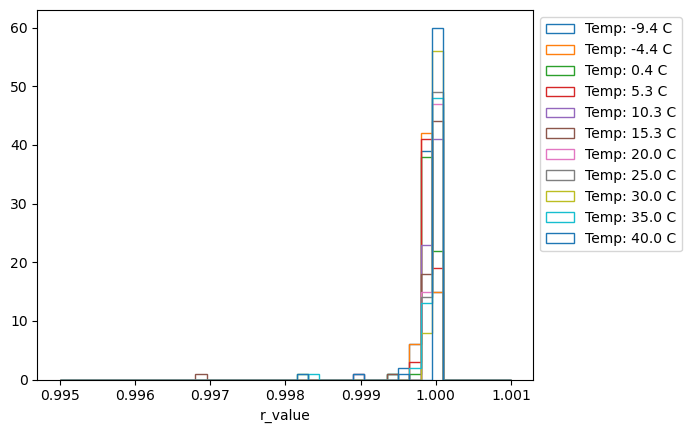

In [11]:
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['Vbd'], bins=50, range=(48, 53), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('$V_{bd}$');
    
plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['std_err'], bins=40, range=(0, 1), histtype='step', label='Temp: %.1f C'%temp);
    plt.xlabel('std_err');
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))    
    plt.xlabel('$\delta V_{bd}$')

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['slope'], bins=40, range=(110, 140), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('SPE/V');

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['r_value'], bins=40, range=(0.995, 1.001), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('r_value');

In [12]:
pd.set_option('display.max_rows', None)
df

chan       slope  temp    intercept   r_value       p_value   std_err  \
0       0  121.201731  -9.4 -5999.594014  0.999926  1.171225e-14  0.228286   
1       1  125.384734  -9.4 -6209.827436  0.999824  2.399636e-13  0.351640   
2       2  126.869904  -9.4 -6286.549036  0.999855  1.196512e-13  0.318515   
3       3  125.032229  -9.4 -6196.849035  0.999687  1.788429e-12  0.468904   
4       4  122.210396  -9.4 -6050.478647  0.999575  5.200267e-12  0.545609   
5       5  124.058305  -9.4 -6153.008691  0.999844  1.557125e-13  0.331044   
6       6  122.925835  -9.4 -6093.259213  0.999897  3.709507e-14  0.269531   
7       7  122.272663  -9.4 -6053.301634  0.999817  2.705997e-13  0.357589   
8       8  127.138034  -9.4 -6301.399712  0.999843  1.592036e-13  0.331865   
9       9  128.300568  -9.4 -6348.664209  0.999930  9.669495e-15  0.222038   
10     10  125.560729  -9.4 -6224.353840  0.999737  9.659459e-13  0.429476   
11     11  125.220308  -9.4 -6199.970763  0.999873  7.550685e-14  0.298004   
12     12  125.518671  -9.4 -6207.670559  0.999970  4.675082e-16  0.143957   
13     13  127.231337  -9.4 -6300.531208  0.999760  7.025197e-13  0.409936   
14     14  126.812364  -9.4 -6288.164117  0.999866  9.272216e-14  0.307337   
15     15  125.447964  -9.4 -6214.527864  0.999732  1.032204e-12  0.433272   
16     16  123.324561  -9.4 -6113.862461  0.999918  1.636302e-14  0.239818   
17     17  126.603530  -9.4 -6263.443891  0.999935  7.217641e-15  0.212910   
18     18  123.305407  -9.4 -6114.530578  0.999837  1.822303e-13  0.338505   
19     19  124.803867  -9.4 -6194.047460  0.999867  8.845951e-14  0.305548   
20     20  123.959667  -9.4 -6141.232015  0.999940  5.627701e-15  0.205761   
21     21  123.912099  -9.4 -6143.778727  0.999843  1.598854e-13  0.332191   
22     22  122.744235  -9.4 -6089.797917  0.999979  1.451576e-16  0.122193   
23     23  122.487832  -9.4 -6075.286587  0.999901  3.193721e-14  0.263989   
24     24  129.521002  -9.4 -6423.405613  0.999926  1.129604e-14  0.227534   
25     25  129.693628  -9.4 -6427.399075  0.999966  7.263252e-16  0.153627   
26     26  126.670297  -9.4 -6276.855813  0.999929  9.747272e-15  0.222607   
27     27  128.442930  -9.4 -6374.706947  0.999870  8.211925e-14  0.302320   
28     28  127.456665  -9.4 -6311.092957  0.999854  1.238466e-13  0.319858   
29     29  128.420229  -9.4 -6372.429961  0.999900  3.236287e-14  0.264610   
30     30  128.825900  -9.4 -6402.709154  0.999888  4.846341e-14  0.280771   
31     31  125.770569  -9.4 -6228.547180  0.999940  5.425119e-15  0.204607   
32     32  120.108073  -9.4 -5883.791671  0.999942  4.820196e-15  0.199005   
33     33  119.364933  -9.4 -5874.636754  0.999858  1.137125e-13  0.314066   
34     34  120.470737  -9.4 -5933.418193  0.999973  3.345629e-16  0.136671   
35     35  118.972168  -9.4 -5856.511963  0.999888  4.857797e-14  0.278184   
36     36  119.955667  -9.4 -5931.218972  0.999951  2.772046e-15  0.185598   
37     37  120.300529  -9.4 -5967.241928  0.999973  3.382867e-16  0.137863   
38     39  121.012131  -9.4 -5986.770288  0.999952  2.542404e-15  0.183421   
39     40  126.465604  -9.4 -6215.838276  0.999939  5.969764e-15  0.205862   
40     41  127.085367  -9.4 -6253.978359  0.999929  9.966973e-15  0.221776   
41     42  129.658504  -9.4 -6380.196559  0.999950  2.886281e-15  0.185776   
42     43  127.735666  -9.4 -6294.174417  0.999985  3.832456e-17  0.100334   
43     44  127.486137  -9.4 -6281.469156  0.999909  2.369151e-14  0.251292   
44     45  126.729062  -9.4 -6250.249922  0.999966  7.242590e-16  0.152825   
45     46  126.469774  -9.4 -6231.258056  0.999977  2.025262e-16  0.127262   
46     47  129.966099  -9.4 -6415.392015  0.999959  1.424663e-15  0.168478   
47     48  121.360431  -9.4 -5986.510710  0.999961  1.206374e-15  0.164410   
48     49  123.764791  -9.4 -6118.362004  0.999923  1.309095e-14  0.231638   
49     50  120.327730  -9.4 -5936.524047  0.999509  8.636668e-12  0.584610   
50     51  125.931895  -9.4